в папке data

Данные в файлах записаны в таком формате 
TICKER, PER, DATE, TIME, CLOSE, VOL

In [226]:
import matplotlib.pyplot as plt
import os
from datetime import datetime
import math
import numpy as np
import pandas as pd

In [160]:
# Создаем папку для графиков, если её нет
if not os.path.exists('plots'):
    os.makedirs('plots')

In [161]:
# Получаем список всех файлов в папке data
data_files = os.listdir('data')

In [162]:
# Для каждого файла парсим его данные

DATA = []

for file_name in data_files:
    if file_name.endswith('.txt'):
        # Читаем файл
        file_path = os.path.join('data', file_name)
        
        dates = []
        close_prices = []
        ticker = file_name.split('_')[0]
        vol = []

        buffer = {
            'TICKER': ticker,
            'DATES': [],
            'CLOSE_PRICES': [],
            'VOLUMES': []
        }

        
        with open(file_path, 'r') as file:
            for line in file:
                # Разбиваем строку по запятой
                parts = line.strip().split(',')
                if len(parts) >= 6:  # Проверяем, что строка содержит все нужные данные
                    buffer['DATES'].append(datetime.strptime(parts[2], "%y%m%d"))
                    buffer['CLOSE_PRICES'].append(float(parts[4]))
                    buffer['VOLUMES'].append(float(parts[5]))

        DATA.append(buffer)

In [163]:
# Функция для построения графика

def plot_data(data):

    plt.figure(figsize=(12, 6))

    # Строим график
    plt.plot(data['DATES'], data['CLOSE_PRICES'], linewidth=1, color='red')

    # Настраиваем внешний вид графика
    plt.title(f"История цены закрытия - {data['TICKER']}")
    plt.xlabel('Дата')
    plt.ylabel('Цена закрытия')

    # Поворачиваем метки на оси X для лучшей читаемости
    plt.xticks(rotation=45)

    # Добавляем сетку
    plt.grid(True, linestyle='--', alpha=0.7)

    # Настраиваем расположение элементов
    plt.tight_layout()

    # Показываем график
    plt.show() 

Нарисуем все графики цен закрытия

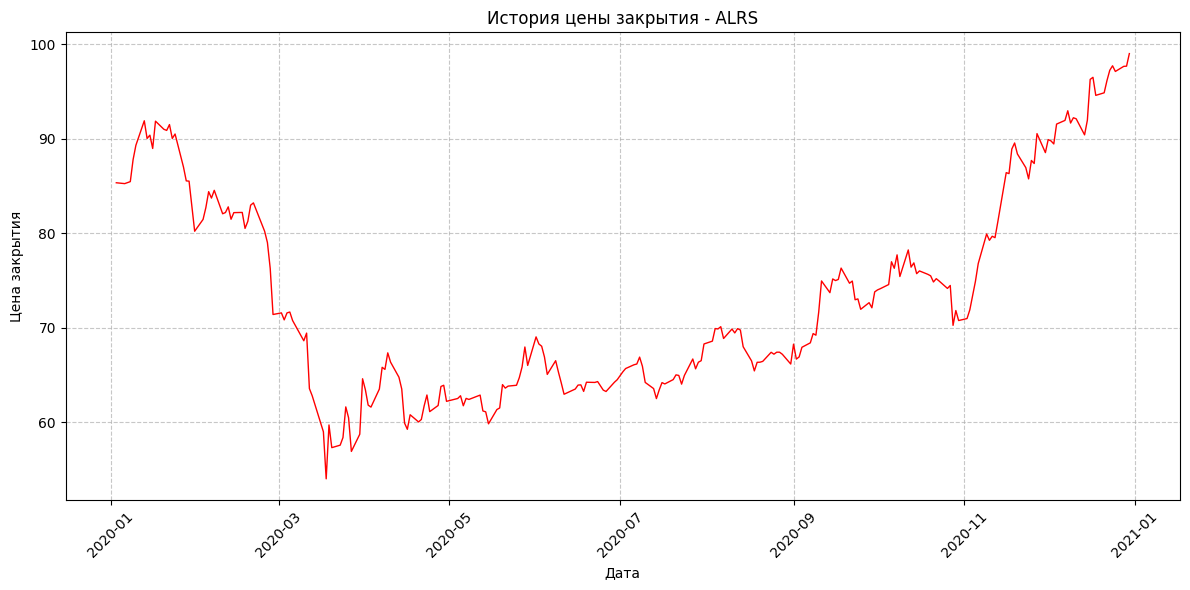

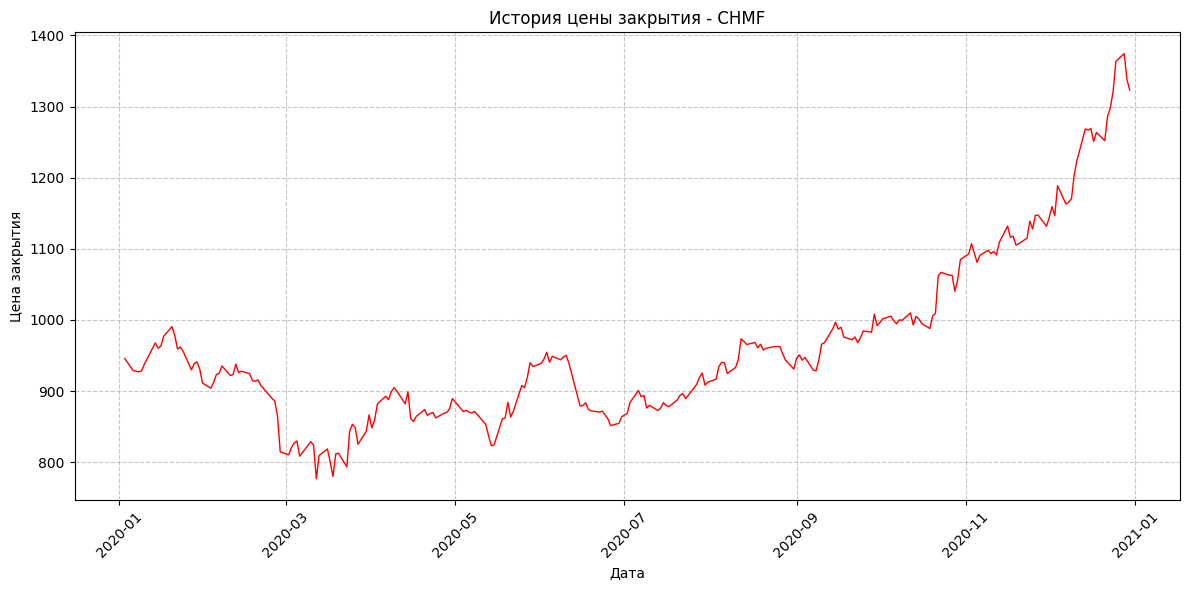

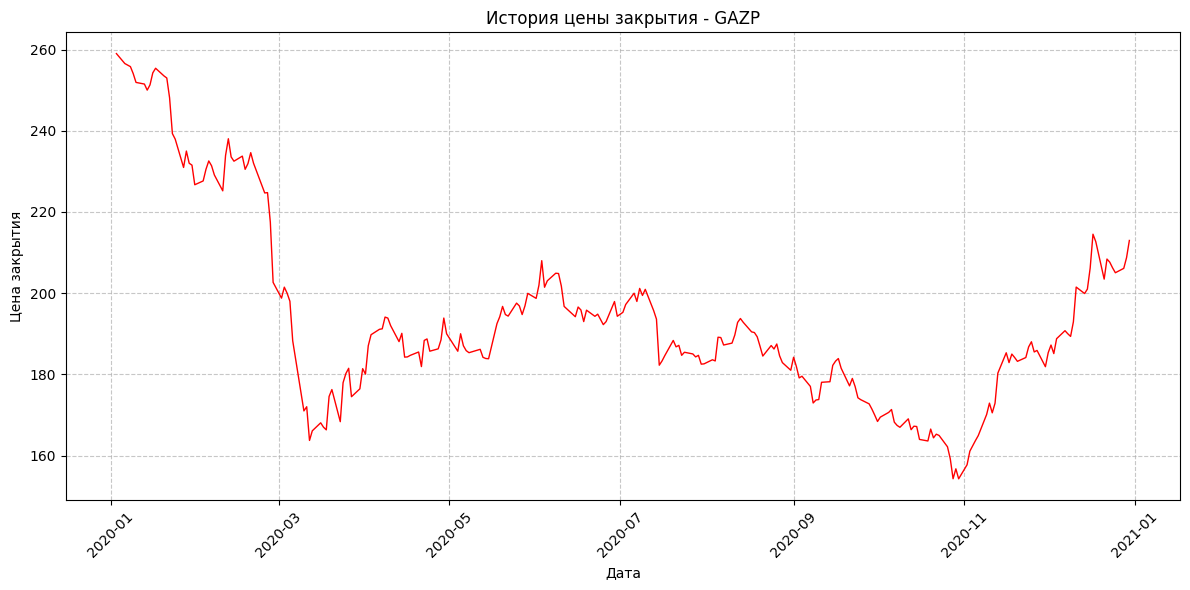

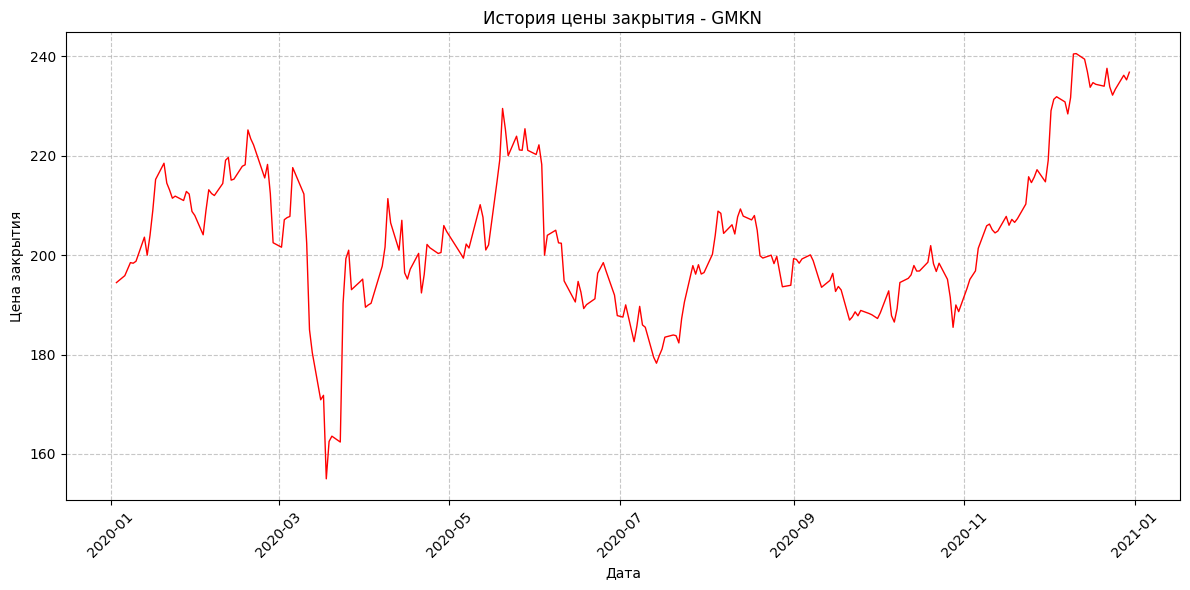

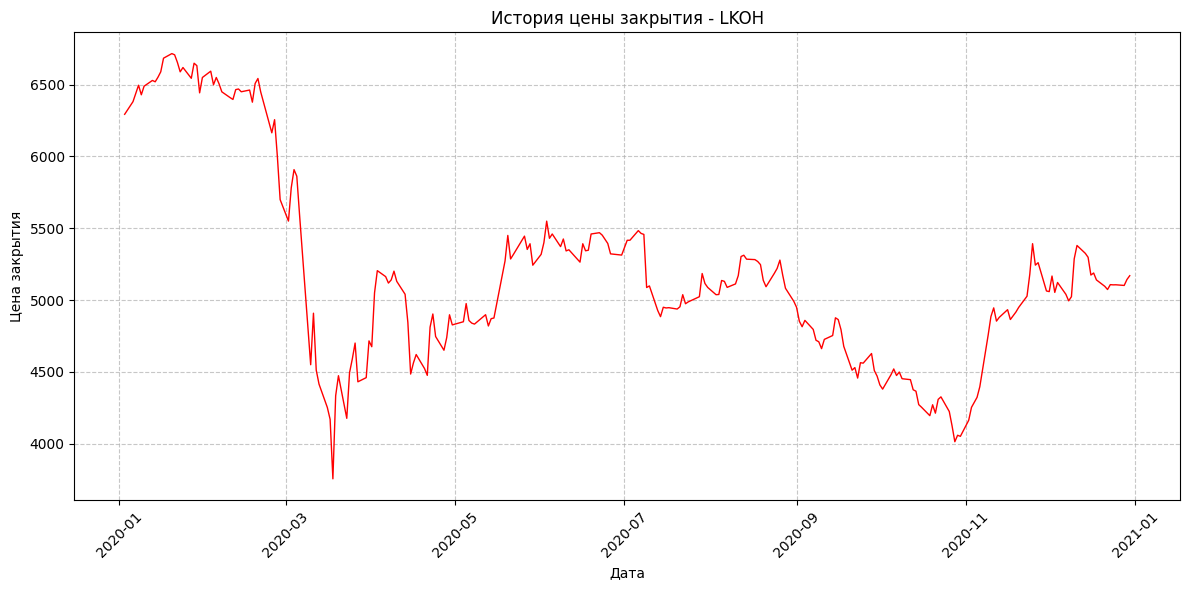

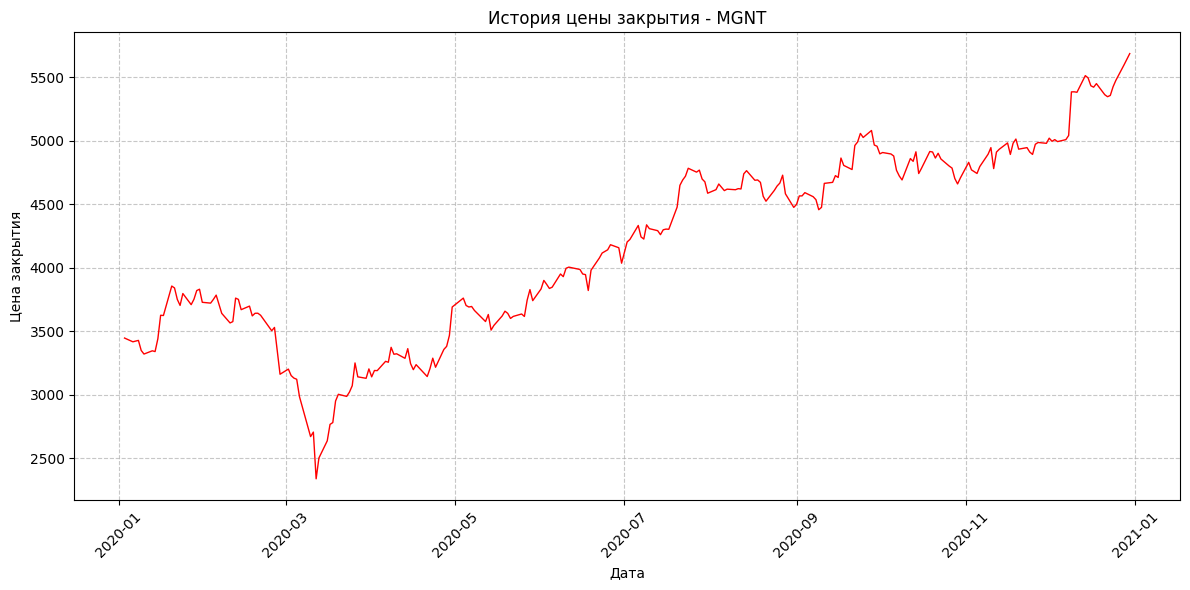

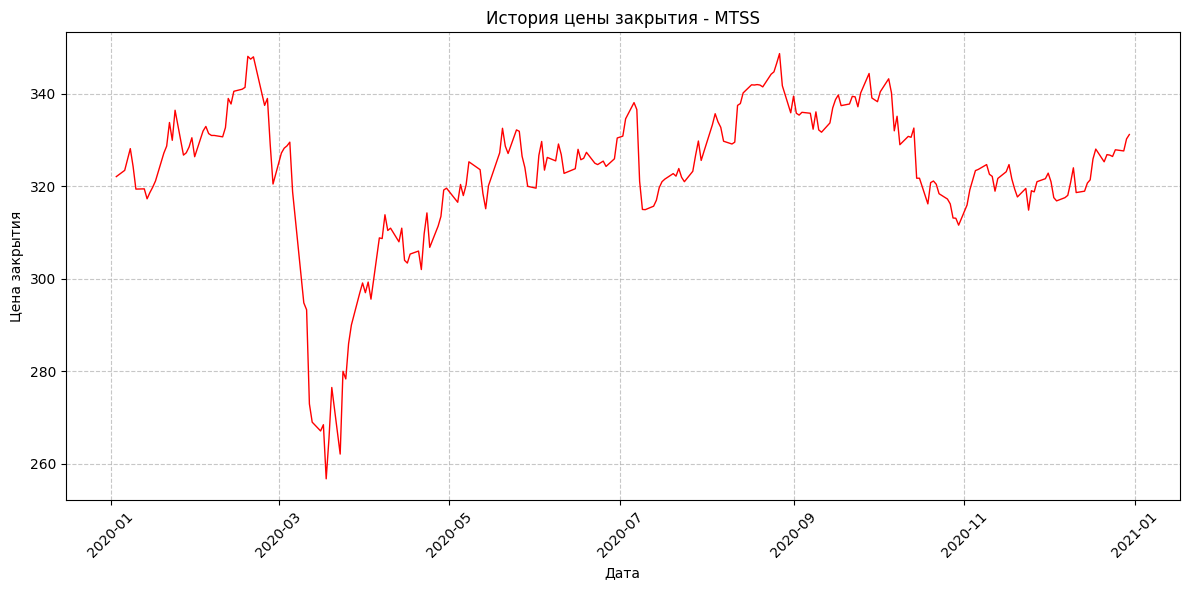

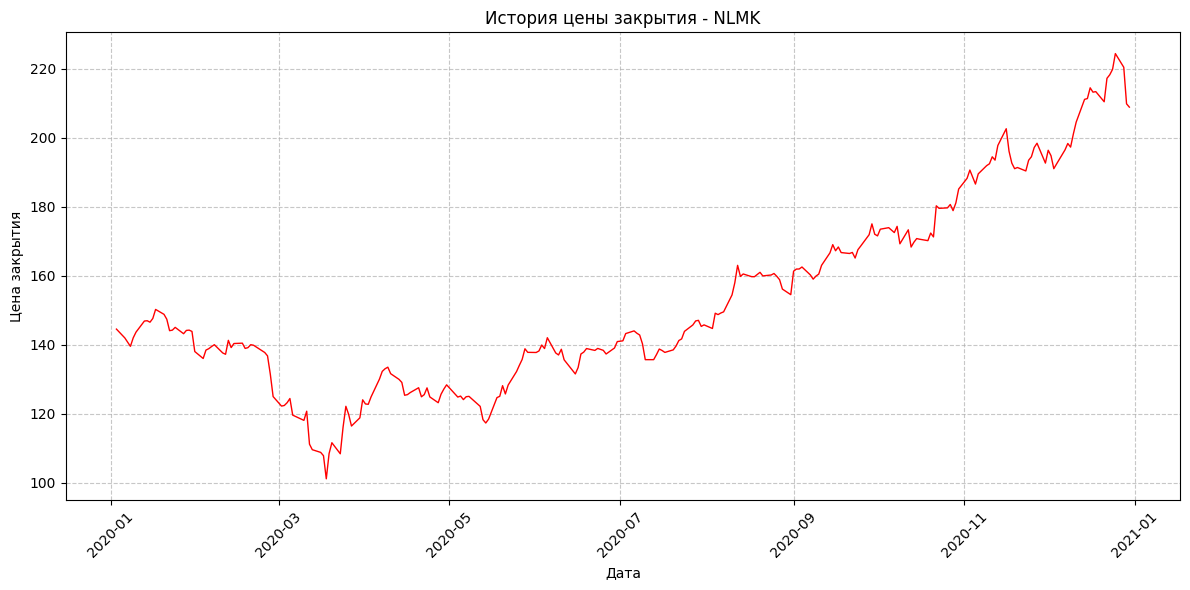

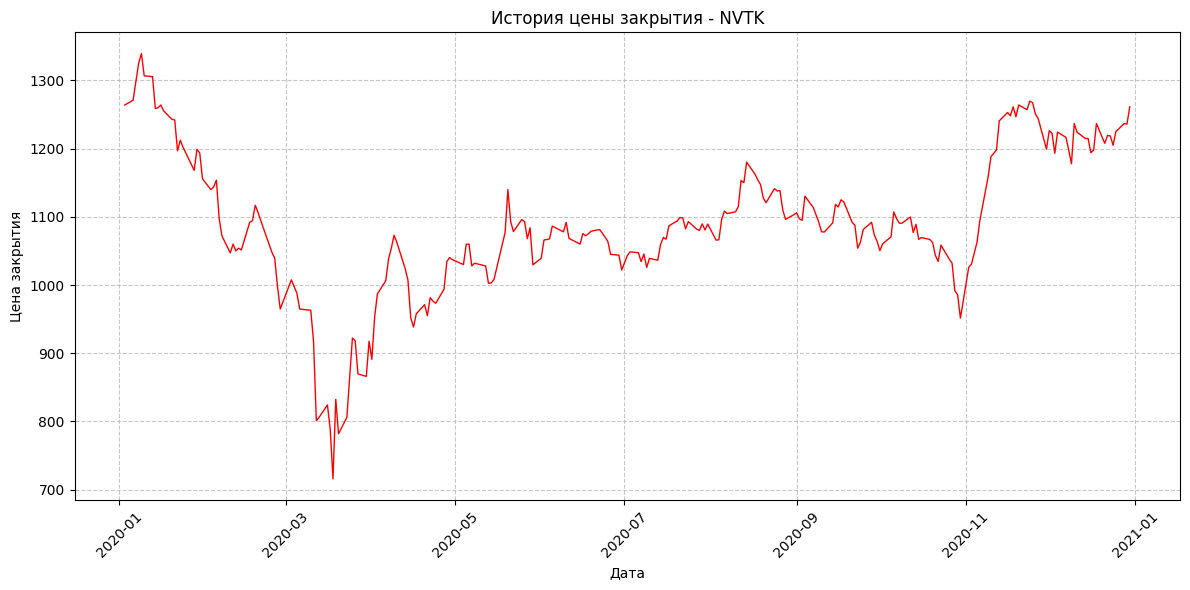

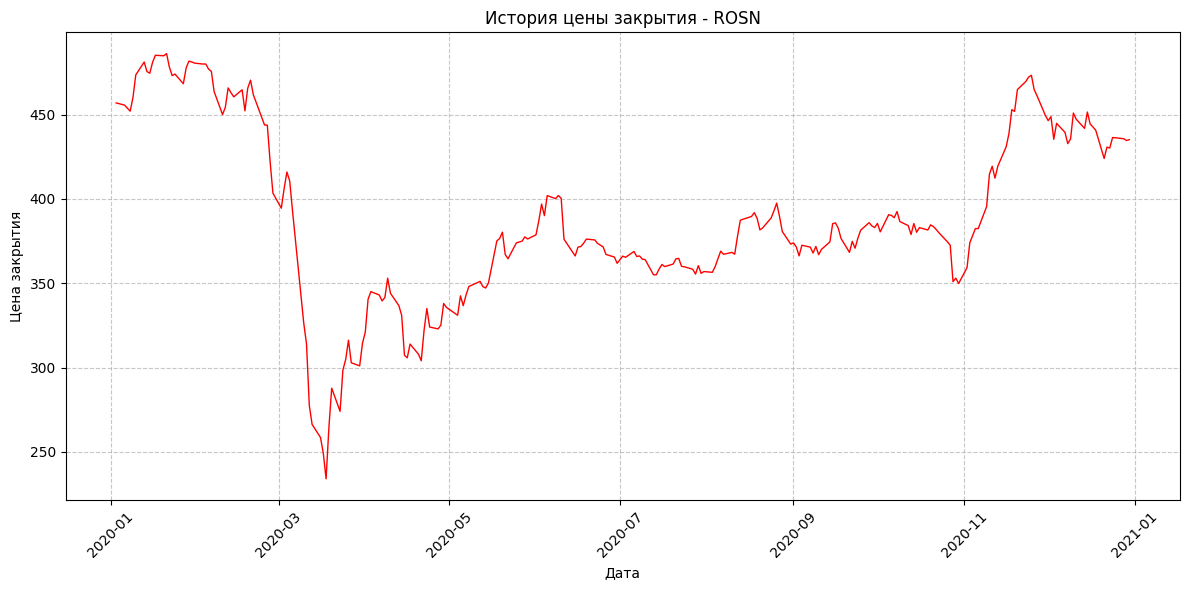

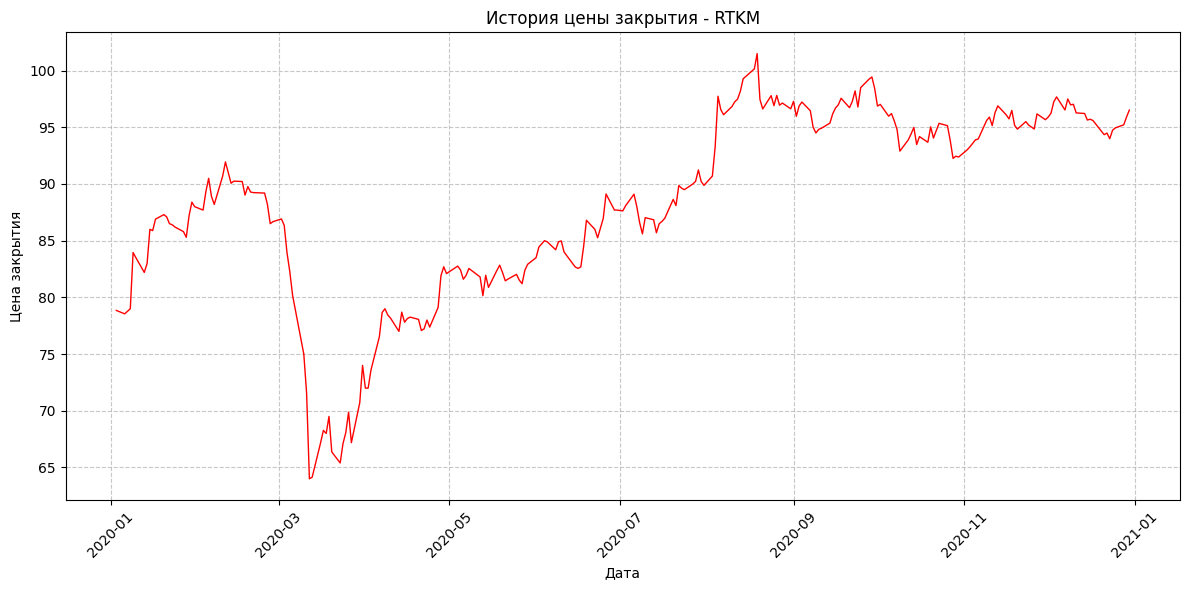

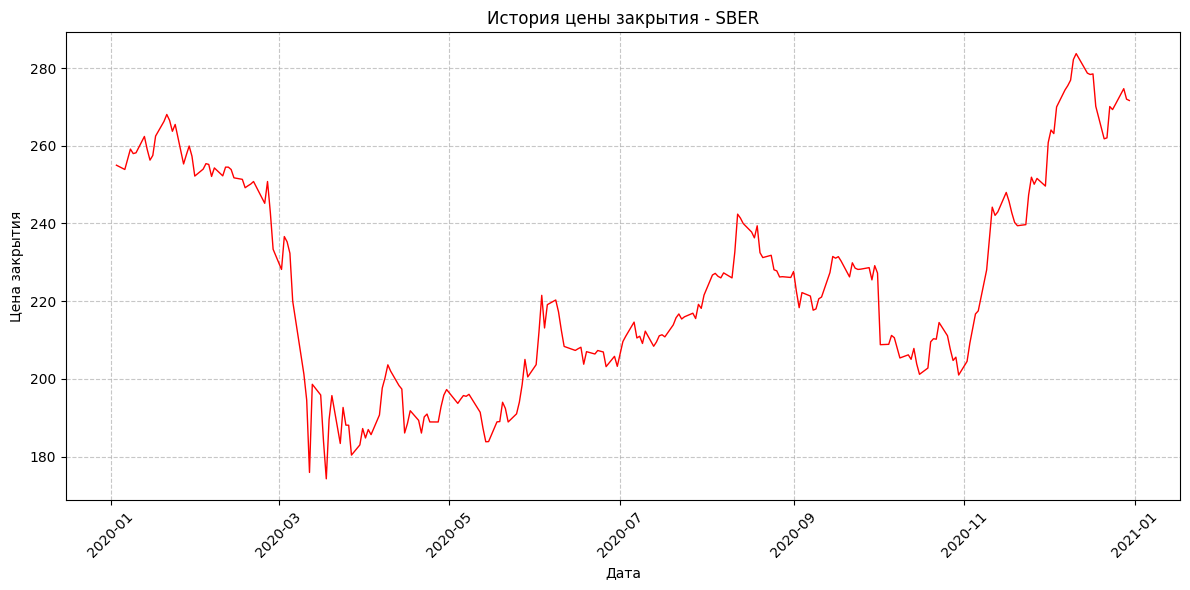

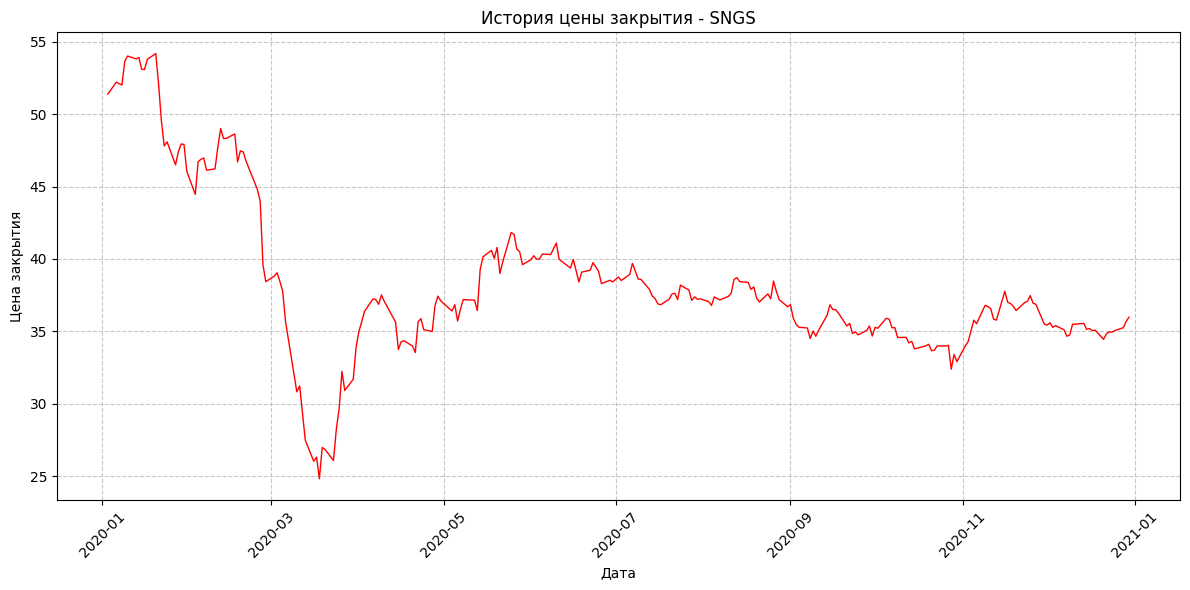

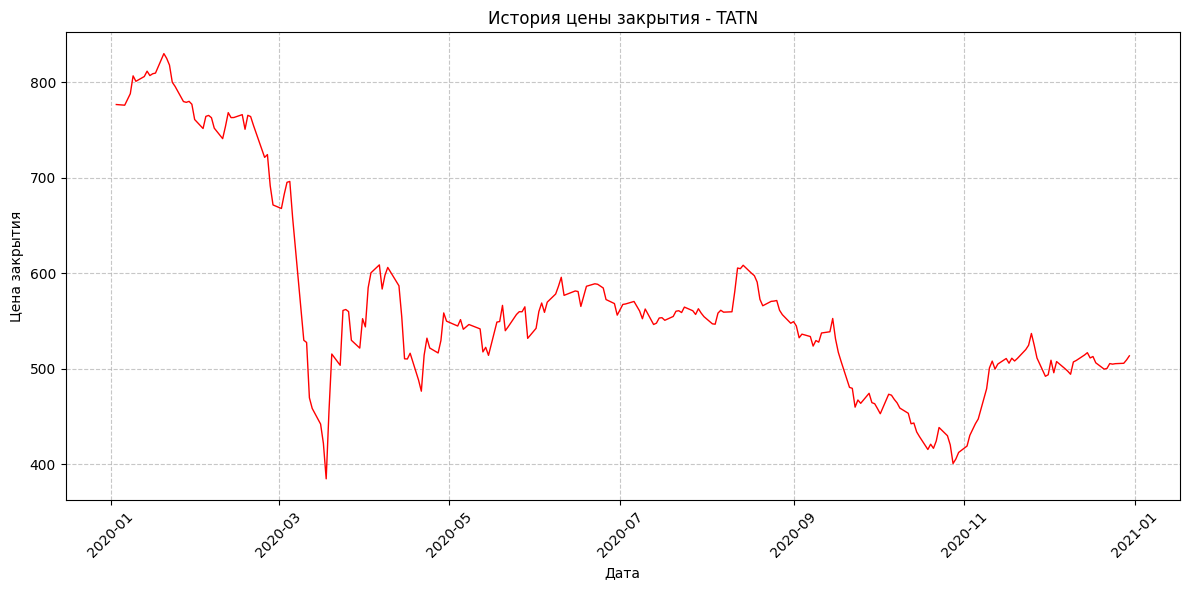

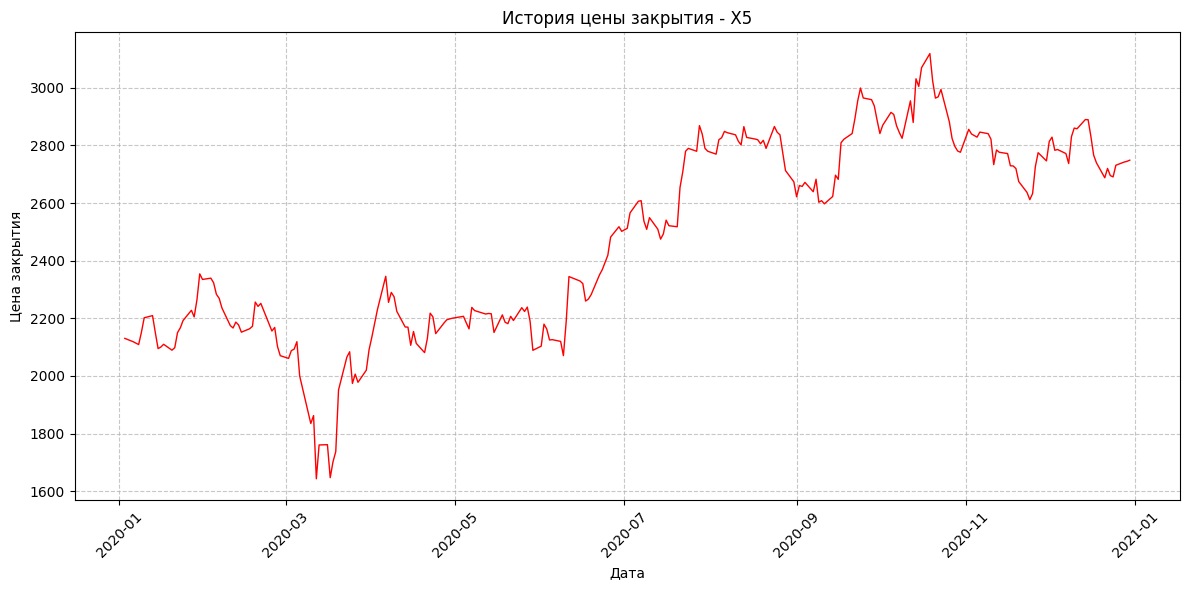

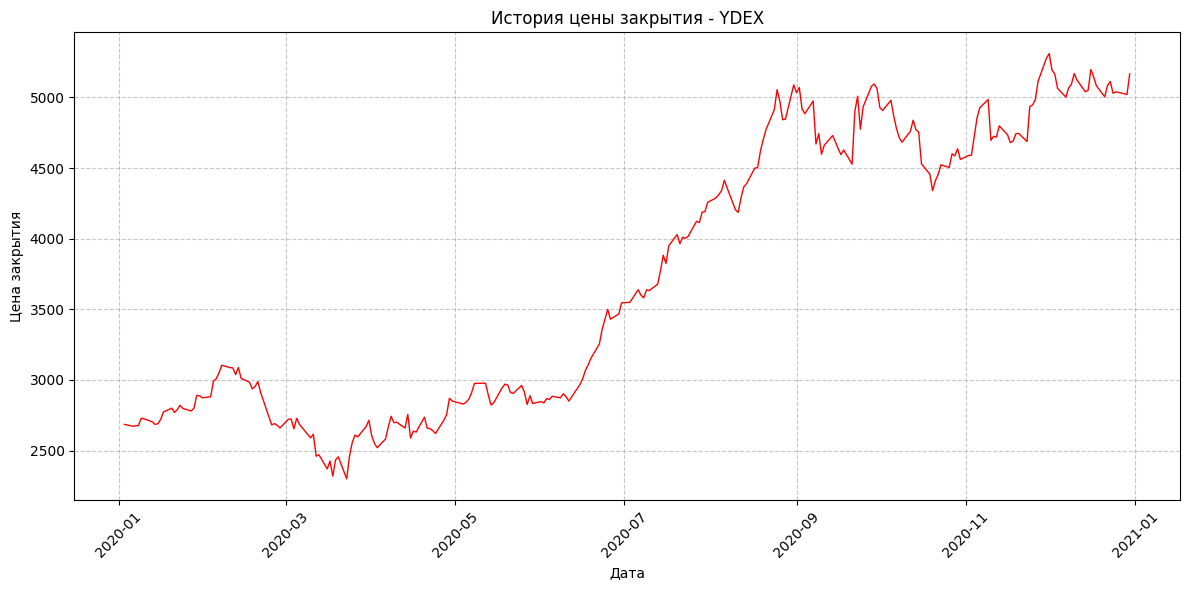

In [164]:
for data in DATA:
    plot_data(data)

Реализуем рассчет метрики кластеризации

In [165]:
def calculate_sma(values, window):
    """
    Рассчитывает простую скользящую среднюю (SMA) для списка значений.
    
    Args:
        values (list): Список числовых значений
        window (int): Размер окна (количество дней)
    
    Returns:
        list: Список значений SMA
    """
    if not values or window <= 0:
        return []
    
    if window > len(values):
        return []
    
    sma_values = []
    for i in range(window - 1, len(values)):
        window_values = values[i - window + 1 : i]
        sma = sum(window_values) / window
        sma_values.append(sma)
    
    return sma_values

Отрисовка графиков как виджетов

%matplotlib widget

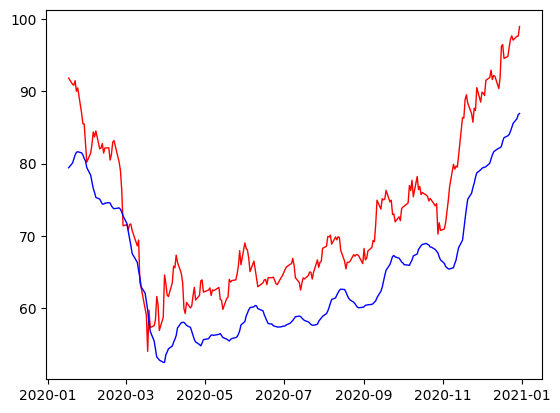

In [166]:
plt.plot(DATA[0]['DATES'][9::], DATA[0]['CLOSE_PRICES'][9::], color='red', linewidth=1)
plt.plot(DATA[0]['DATES'][9::], calculate_sma(DATA[0]['CLOSE_PRICES'], 10), color='blue', linewidth=1)
plt.show()

Рассчет гамма метрики

In [167]:
def gamma_metric(mean, real):
    """
    Вычисляет гамма метрики для ряда данных
    
    Parameters
    ----------
    mean : list
        Значения скользящего среднего в моменте времени t
    real : list
        Значения элемента ряда в момент времени t
    Returns
    -------
    list
        Метрики
    
    Raises
    ------
    ValueError
        Если длины массивов не равны
    """
    
    # mean - Значение скользящего среднего в моменте времени t
    # real - Значение элемента ряда в момент времени t

    if(len(mean) != len(real)):
        raise ValueError("Mean and real must have the same length")
    
    gamma = []

    for i in range(len(mean) - 1):
        VNMi = (real[i + 1] - mean[i + 1]) / ( real[i]**2 + (real[i + 1] - mean[i + 1])**2 )**0.5
        gamma.append(VNMi)

    return gamma

In [168]:
gamma_metric([0,0,0], [1, 2, 3])

[0.8944271909999159, 0.8320502943378437]

In [169]:
gamma_metric([0,0,0], [2, 3, 4])

[0.8320502943378437, 0.8]

In [170]:
gamma_metric([0,0,0], [8, 9, 10])

[0.7474093186836597, 0.7432941462471664]

In [171]:
gamma_metric([0,0,0], [80, 90, 100])

[0.7474093186836598, 0.7432941462471663]

Дельта метрика

In [172]:
def find_angle(a,b,c):
    if a + b < c or b + c < a or c + a < b:
        raise ValueError("Triangle inequality is not satisfied")
    angle_a = math.degrees(math.acos((b**2 + c**2 - a**2) / (2 * b * c)))
    return angle_a

In [173]:
def delta_metric(mean, real):
    """
    Вычисляет дельта метрики для ряда данных
    
    Parameters
    ----------
    mean : list
        Значения скользящего среднего в моменте времени t
    real : list
        Значения элемента ряда в момент времени t
    Returns
    -------
    list
        Метрики
    
    Raises
    ------
    ValueError
        Если длины массивов не равны
    """
    
    # mean - Значение скользящего среднего в моменте времени t
    # real - Значение элемента ряда в момент времени t

    if(len(mean) != len(real)):
        raise ValueError("Mean and real must have the same length")
    
    delta = []

    for i in range(len(mean) - 1):

        negative_coefficient = -1

        Ri_ = real[i+1]
        Ri = real[i]
        Si = mean[i]

        if(Ri >= Ri_ and Si >= Ri_):
            ## Для случая когда следущая точка ниже среднего и ниже предыдущей точки
            a = max(Ri, Si) - min(Ri, Si)
            b = ( 1 + (max(Ri, Si) - Ri_)**2 )**0.5
            c = ( 1 + (min(Ri, Si) - Ri_)**2 )**0.5

            delta.append(find_angle(a,b,c))

        elif(Ri <= Ri_ and Si <= Ri_):
            ## Для случая когда следущая точка выше среднего и выше предыдущей точки
            a = max(Ri, Si) - min(Ri, Si)
            b = ( 1 + ( Ri_ - min(Ri, Si) )**2 )**0.5
            c = ( 1 + ( Ri_ - max(Ri, Si) )**2 )**0.5

            delta.append(find_angle(a,b,c) * negative_coefficient)
        
        else:
            a = max(Ri, Si) - min(Ri, Si)
            b = (1 + ( max(Ri, Si) - Ri_ )**2 )**0.5
            c = (1 + ( Ri_ - min(Ri, Si) )**2 )**0.5

            if(Ri > Si):
                delta.append(find_angle(a,b,c))
            else:
                delta.append(find_angle(a,b,c) * negative_coefficient)
        
    return delta


In [174]:
delta_metric([0,0,0], [1, 2, 3])

[-18.434948822921974, -26.565051177077965]

In [175]:
delta_metric([0,0,0], [100, 200, 300])

[-0.28646218740594925, -0.38195347332370977]

In [176]:
delta_metric([0,0,0], [0.1, 0.2, 0.3])

[-5.599339336520484, -10.988651096494014]

In [177]:
delta_metric([0,0,0], [-1, -2, -3])

[18.434948822921974, 26.565051177077965]

In [178]:
delta_metric([0,0,0], [3, 2, 1])

[108.434948822922, 89.99999999999999]

In [179]:
delta_metric([0,0,0], [-3, -2, -1])

[-108.434948822922, -89.99999999999999]

Рассчет косинусного расстояния (стандартная метрика)

In [180]:
def calculate_cosine_distance_manual(ts_a, ts_b):
    """
    Расчет косинусного расстояние между двумя временными рядами вручную.

    Параметры:
    ts_a (list или numpy.ndarray): Первый временной ряд.
    ts_b (list или numpy.ndarray): Второй временной ряд.

    Возвращает:
    float: Косинусное расстояние.
    """
    ts_a_np = np.asarray(ts_a, dtype=float)
    ts_b_np = np.asarray(ts_b, dtype=float)

    # Убедимся, что оба входных массива одномерны, если они не скаляры
    if ts_a_np.ndim == 0: ts_a_np = ts_a_np.reshape(1) # Используем reshape
    if ts_b_np.ndim == 0: ts_b_np = ts_b_np.reshape(1)

    if len(ts_a_np) != len(ts_b_np):
        raise ValueError(f"Временные ряды должны быть одинаковой длины. Получено {len(ts_a_np)} и {len(ts_b_np)}")
    if len(ts_a_np) == 0:
        return np.nan 

    dot_product = np.sum(ts_a_np * ts_b_np)
    norm_a = np.sqrt(np.sum(ts_a_np**2))
    norm_b = np.sqrt(np.sum(ts_b_np**2))
    denominator = norm_a * norm_b

    if denominator == 0:
        return np.nan 
    else:
        return float(1 - dot_product / denominator)

In [181]:
calculate_cosine_distance_manual([1,2,3], [2,2,3])

0.027694414671753376

Расчет коэффициента корреляции Пирсона.

In [182]:
def calculate_pearson_distance_manual(ts_a, ts_b):
    """
    Расчет коэффициента корреляции Пирсона вручную.

    Параметры:
    ts_a (list или numpy.ndarray): Первый отрезок временного ряда.
    ts_b (list или numpy.ndarray): Второй отрезок временного ряда.

    Возвращает:
    float: Коэффициент корреляции Пирсона.
    """
    if len(ts_a) != len(ts_b):
        raise ValueError("Временные ряды должны быть одинаковой длины.")
    if len(ts_a) == 0:
        return np.nan # Или поднять ошибку, в зависимости от желаемого поведения
    if len(ts_a) == 1:
        return 1.0 # Если только одна точка, то корреляция идеальна (или undefined, но 1.0 часто используется)

    # Преобразуем в NumPy массивы для удобства
    ts_a = np.array(ts_a)
    ts_b = np.array(ts_b)

    # 1. Вычисляем средние значения
    mean_a = np.mean(ts_a)
    mean_b = np.mean(ts_b)

    # 2. Вычисляем числитель (сумму произведений отклонений от среднего)
    numerator = np.sum((ts_a - mean_a) * (ts_b - mean_b))

    # 3. Вычисляем знаменатели (стандартные отклонения)
    # Используем np.sqrt(np.sum(...)) вместо np.std(), чтобы избежать деления на N-1 или N
    # и точно следовать формуле для корреляции Пирсона.
    denominator_a = np.sqrt(np.sum((ts_a - mean_a)**2))
    denominator_b = np.sqrt(np.sum((ts_b - mean_b)**2))

    # 4. Вычисляем произведение знаменателей
    denominator = denominator_a * denominator_b

    # Избегаем деления на ноль, если один из рядов имеет нулевую дисперсию (все значения одинаковы)
    if denominator == 0:
        return None # Корреляция неопределена
    else:
        return float(1 - numerator / denominator)

In [183]:
calculate_pearson_distance_manual([1,2,3], [2,2,3])

0.13397459621556151

К-средних для Евклидового расстояния

In [184]:
class KMeans:
    def __init__(self, n_clusters=3, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.labels = None
        self.inertia_ = None

    def _initialize_centroids(self, X_np): # X_np ожидается как numpy.ndarray
        if self.random_state is not None:
            np.random.seed(self.random_state)
        indices = np.random.choice(X_np.shape[0], self.n_clusters, replace=False)
        self.centroids = X_np[indices]

    def _assign_clusters(self, X_np): # X_np ожидается как numpy.ndarray
        distances = np.sqrt(np.sum((X_np - self.centroids[:, np.newaxis])**2, axis=2))
        self.labels = np.argmin(distances, axis=0)

    def _update_centroids(self, X_np): # X_np ожидается как numpy.ndarray
        new_centroids = np.zeros_like(self.centroids)
        for k in range(self.n_clusters):
            points_in_cluster = X_np[self.labels == k]
            if len(points_in_cluster) > 0:
                new_centroids[k] = np.mean(points_in_cluster, axis=0)
            else:
                new_centroids[k] = self.centroids[k]
        self.centroids = new_centroids

    def _calculate_wcss(self, X_np): # X_np ожидается как numpy.ndarray
        wcss = 0
        for k in range(self.n_clusters):
            points_in_cluster = X_np[self.labels == k]
            if len(points_in_cluster) > 0:
                wcss += np.sum((points_in_cluster - self.centroids[k])**2)
        self.inertia_ = wcss
        return wcss # Возвращаем WCSS

    def fit(self, X):
        # Преобразуем входной список/ndarray в numpy.ndarray в начале метода
        X_np = np.asarray(X, dtype=float)

        if X_np.ndim != 2:
            raise ValueError("Входные данные X должны быть 2-мерным массивом (N точек, D измерений).")
        if self.n_clusters > X_np.shape[0]:
            raise ValueError("Количество кластеров (n_clusters) не может быть больше количества точек данных.")
        if self.n_clusters <= 0:
            raise ValueError("Количество кластеров (n_clusters) должно быть положительным.")
        if self.n_clusters == 1 and X_np.shape[0] > 1:
             print("Предупреждение: для K=1 коэффициент силуэта обычно не вычисляется или равен 0.")
        
        # Передаем X_np во все внутренние методы
        self._initialize_centroids(X_np)

        for i in range(self.max_iter):
            old_labels = np.copy(self.labels)
            self._assign_clusters(X_np)
            self._update_centroids(X_np)
            if np.array_equal(old_labels, self.labels):
                break
        
        self._calculate_wcss(X_np) # Передаем X_np
        return self

    def predict(self, X):
        if self.centroids is None:
            raise RuntimeError("Модель не обучена. Используйте fit() перед predict().")
        # Преобразуем входной список/ndarray в numpy.ndarray
        X_np = np.asarray(X, dtype=float)
        
        if X_np.ndim != 2:
            raise ValueError("Входные данные X должны быть 2-мерным массивом (N точек, D измерений).")
        
        # Передаем X_np во внутренние расчеты
        distances = np.sqrt(np.sum((X_np - self.centroids[:, np.newaxis])**2, axis=2))
        return np.argmin(distances, axis=0)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels

проверим на случайных списках

In [185]:
import random

def generate_similar_lists(base_list, count=10, variation=0.5):
    similar_lists = []
    for _ in range(count):
        # Добавляем случайное отклонение в диапазоне [-variation, +variation] к каждому элементу
        similar_list = [x + random.uniform(-variation, variation) for x in base_list]
        # Округляем до 2 знаков после запятой для читаемости
        similar_list = [round(val, 2) for val in similar_list]
        similar_lists.append(similar_list)
    return similar_lists

# Базовые списки
base_lists = [
    [1, 2, 3, 4, 5],
    [2, 3, 4, 5, 6],
    [3, 4, 5, 6, 7]
]

# Генерация по 10 похожих списков для каждого базового
variation = 0.3  # Можно изменить на любое значение float (например, 0.1, 0.5, 1.0)
all_similar_lists = []
for base in base_lists:
    all_similar_lists.append(generate_similar_lists(base, variation=variation))

In [186]:
test_lists = []
for l in all_similar_lists:
    for i in l:
        test_lists.append(i)

Модель для к-средних на эвклидовом расстоянии

In [187]:
my_kmeans = KMeans(n_clusters=3, max_iter=100, random_state=0)
my_labels = my_kmeans.fit_predict(test_lists)

print("\nМетки кластеров, полученные моей реализацией K-Means:")
print(my_labels)

print("\nНайденные центроиды моей реализации:")
print(my_kmeans.centroids)


Метки кластеров, полученные моей реализацией K-Means:
[0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1]

Найденные центроиды моей реализации:
[[1.026 1.97  3.005 4.061 5.02 ]
 [3.066 3.997 4.981 5.911 7.026]
 [1.877 3.05  3.958 5.036 5.99 ]]


In [188]:
# Пример использования predict на новых данных
new_data = np.array([
    [1.1, 2.3, 3.2, 4.1, 5.0], # Похож на кластер 1
    [2.5, 3.6, 4.7, 5.8, 6.9], # Похож на кластер 2
    [1.918, 3.001, 3.943, 4.938, 5.93] # Похож на кластер 3
])
predicted_labels = my_kmeans.predict(new_data)
print(f"\nПредсказанные метки для новых данных:\n{new_data}\n{predicted_labels}")


Предсказанные метки для новых данных:
[[1.1   2.3   3.2   4.1   5.   ]
 [2.5   3.6   4.7   5.8   6.9  ]
 [1.918 3.001 3.943 4.938 5.93 ]]
[0 1 2]


Проверим по методу локтя

Обучаем K-Means для K = 1...
Предупреждение: для K=1 коэффициент силуэта обычно не вычисляется или равен 0.
  WCSS для K = 1: 102.67
Обучаем K-Means для K = 2...
  WCSS для K = 2: 27.76
Обучаем K-Means для K = 3...
  WCSS для K = 3: 4.31
Обучаем K-Means для K = 4...
  WCSS для K = 4: 3.75
Обучаем K-Means для K = 5...
  WCSS для K = 5: 3.37
Обучаем K-Means для K = 6...
  WCSS для K = 6: 3.13
Обучаем K-Means для K = 7...
  WCSS для K = 7: 2.92
Обучаем K-Means для K = 8...
  WCSS для K = 8: 2.82
Обучаем K-Means для K = 9...
  WCSS для K = 9: 2.68
Обучаем K-Means для K = 10...
  WCSS для K = 10: 2.65


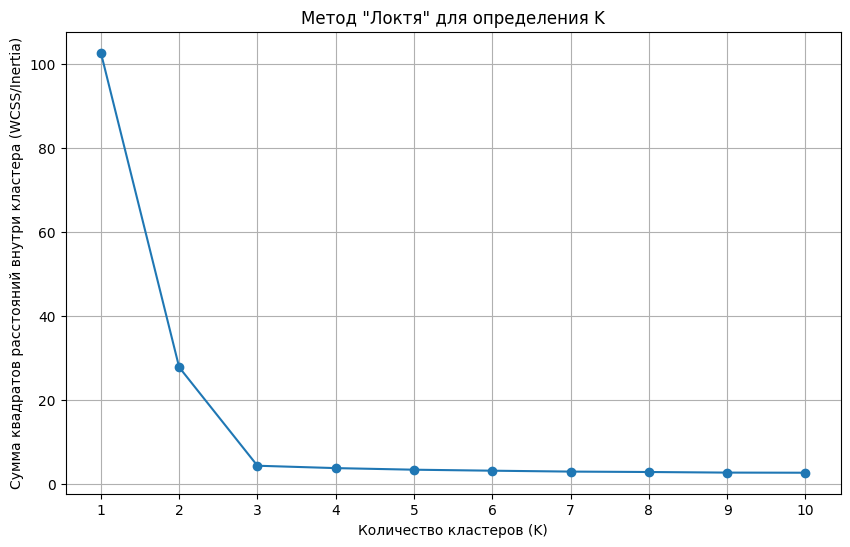

In [189]:
wcss_values = [] # Список для хранения значений WCSS
max_k = 10       # Максимальное количество кластеров для проверки

# Запускаем K-Means для K от 1 до max_k
for k in range(1, max_k + 1):
    print(f"Обучаем K-Means для K = {k}...")
    kmeans = KMeans(n_clusters=k, max_iter=100, random_state=0)
    kmeans.fit(test_lists)
    wcss_values.append(kmeans.inertia_)
    print(f"  WCSS для K = {k}: {kmeans.inertia_:.2f}")

# Построение графика "локтя"
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), wcss_values, marker='o')
plt.title('Метод "Локтя" для определения K')
plt.xlabel('Количество кластеров (K)')
plt.ylabel('Сумма квадратов расстояний внутри кластера (WCSS/Inertia)')
plt.xticks(range(1, max_k + 1))
plt.grid(True)
plt.show()

функции для метода силуэта

In [190]:
# --- Функции для расчета коэффициента силуэта, теперь принимающие списки ---

def euclidean_distance(point1, point2):
    """Вычисляет евклидово расстояние между двумя точками/векторами (list или np.array)."""
    point1_np = np.asarray(point1, dtype=float)
    point2_np = np.asarray(point2, dtype=float)
    return np.sqrt(np.sum((point1_np - point2_np)**2))

def calculate_silhouette_sample_score(X, labels, current_point_index):
    """
    Вычисляет коэффициент силуэта для одной точки данных (X может быть list или np.array).

    Параметры:
    X (list или numpy.ndarray): Входные данные.
    labels (numpy.ndarray): Метки кластеров для каждой точки.
    current_point_index (int): Индекс точки, для которой вычисляется силуэт.

    Возвращает:
    float: Коэффициент силуэта для данной точки.
    """
    X_np = np.asarray(X, dtype=float) # Преобразуем X в np.array здесь
    n_samples = X_np.shape[0]
    
    if n_samples <= 1:
        return 0.0

    current_point = X_np[current_point_index]
    current_cluster_label = labels[current_point_index]

    points_in_same_cluster = X_np[labels == current_cluster_label]
    
    if len(points_in_same_cluster) <= 1:
        a_i = 0.0
    else:
        distances_to_same_cluster = [
            euclidean_distance(current_point, p) 
            for p in points_in_same_cluster 
            if not np.array_equal(current_point, p) # Исключаем расстояние до самой себя
        ]
        a_i = np.mean(distances_to_same_cluster) if distances_to_same_cluster else 0.0 # Обработка пустого списка

    b_i = float('inf')
    unique_labels = np.unique(labels)
    
    for cluster_label in unique_labels:
        if cluster_label == current_cluster_label:
            continue
        
        points_in_other_cluster = X_np[labels == cluster_label]
        if len(points_in_other_cluster) > 0:
            distances_to_other_cluster = [euclidean_distance(current_point, p) for p in points_in_other_cluster]
            avg_distance_to_other_cluster = np.mean(distances_to_other_cluster)
            b_i = min(b_i, avg_distance_to_other_cluster)
        
    if b_i == float('inf'):
        return 0.0
    
    if max(a_i, b_i) == 0:
        return 0.0
    
    silhouette_coefficient = (b_i - a_i) / max(a_i, b_i)
    return silhouette_coefficient

def calculate_average_silhouette_score(X, labels):
    """
    Вычисляет средний коэффициент силуэта для всего набора данных (X может быть list или np.array).
    """
    X_np = np.asarray(X, dtype=float) # Преобразуем X в np.array здесь
    if len(np.unique(labels)) <= 1 or X_np.shape[0] <= 1:
        return 0.0

    silhouette_scores_per_sample = [
        calculate_silhouette_sample_score(X_np, labels, i) # Передаем X_np
        for i in range(X_np.shape[0])
    ]
    return np.mean(silhouette_scores_per_sample)

проверка по методу силуэта

Вычисляем средний коэффициент силуэта для разных K...
  Обучаем K-Means для K = 2...
    Средний коэффициент силуэта для K = 2: 0.6364
  Обучаем K-Means для K = 3...
    Средний коэффициент силуэта для K = 3: 0.7542
  Обучаем K-Means для K = 4...
    Средний коэффициент силуэта для K = 4: 0.5853
  Обучаем K-Means для K = 5...
    Средний коэффициент силуэта для K = 5: 0.4070
  Обучаем K-Means для K = 6...
    Средний коэффициент силуэта для K = 6: 0.4073
  Обучаем K-Means для K = 7...
    Средний коэффициент силуэта для K = 7: 0.4465
  Обучаем K-Means для K = 8...
    Средний коэффициент силуэта для K = 8: 0.3864
  Обучаем K-Means для K = 9...
    Средний коэффициент силуэта для K = 9: 0.3565
  Обучаем K-Means для K = 10...
    Средний коэффициент силуэта для K = 10: 0.3191


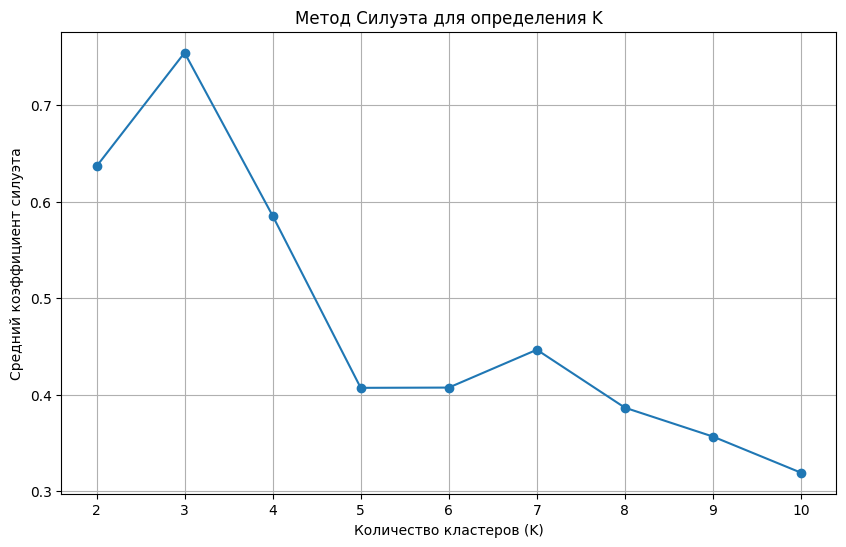

In [191]:
silhouette_scores = [] # Список для хранения средних коэффициентов силуэта
max_k = 10             # Максимальное количество кластеров для проверки

# Запускаем K-Means для K от 2 до max_k (силуэт для K=1 обычно не определен)
# или равен 0 по определению scikit-learn
print("Вычисляем средний коэффициент силуэта для разных K...")
for k in range(2, max_k + 1):
    print(f"  Обучаем K-Means для K = {k}...")
    kmeans = KMeans(n_clusters=k, max_iter=100, random_state=0)
    kmeans.fit(test_lists)
    
    # Используем мою функцию для расчета среднего силуэта
    avg_silhouette = calculate_average_silhouette_score(test_lists, kmeans.labels)
    silhouette_scores.append(avg_silhouette)
    print(f"    Средний коэффициент силуэта для K = {k}: {avg_silhouette:.4f}")

# Построение графика среднего коэффициента силуэта
plt.figure(figsize=(10, 6))
# Ось X начинается с 2, так как мы пропускаем K=1
plt.plot(range(2, max_k + 1), silhouette_scores, marker='o') 
plt.title('Метод Силуэта для определения K')
plt.xlabel('Количество кластеров (K)')
plt.ylabel('Средний коэффициент силуэта')
plt.xticks(range(2, max_k + 1))
plt.grid(True)
plt.show()

Функция универсал для рассчепта метрики силуэта, возвращает оптимальное число кластеров и полные данные

In [242]:
def calcilate_silhouette_score(model, train_data, max_iter_in_model = 100, max_clusters_to_check = 10, random_state_in_model = 0):
    
    silhouette_scores = []          # Список для хранения средних коэффициентов силуэта
    max_k = max_clusters_to_check   # Максимальное количество кластеров для проверки

    # Запускаем K-Means для K от 2 до max_k (силуэт для K=1 обычно не определен)
    # или равен 0 по определению scikit-learn

    for k in range(2, max_k + 1):
        predict_model = model(n_clusters=k, max_iter=max_iter_in_model, random_state=random_state_in_model)
        predict_model.fit(train_data)
        
        # Используем мою функцию для расчета среднего силуэта
        avg_silhouette = calculate_average_silhouette_score(train_data, predict_model.labels)
        silhouette_scores.append(avg_silhouette)
    
    return {
        "silhouette_scores": [float(x) for x in silhouette_scores],
        "best_count_of_clusters": silhouette_scores.index(max(silhouette_scores)) + 2,
        "best_silhouette_score": float(max(silhouette_scores)),
        "model": predict_model
    }

In [193]:
calcilate_silhouette_score(KMeans, test_lists)

{'silhouette_scores': [0.636401177754242,
  0.7541513001036287,
  0.5852544613995333,
  0.40701041507132896,
  0.4072697222074804,
  0.4464756590400123,
  0.38644933068516685,
  0.35651288614571125,
  0.319081386757291],
 'best_count_of_clusters': 3}

функция визуализации коэффициентов силуэта

In [194]:
def visualise_silhouette_score(silhouette_scores):
    
    # Построение графика среднего коэффициента силуэта
    plt.figure(figsize=(12, 6))
    
    # Ось X начинается с 2, так как мы пропускаем K=1
    plt.plot(range(2, len(silhouette_scores["silhouette_scores"]) + 2), silhouette_scores["silhouette_scores"], marker='o') 
    plt.title(f'Метод Силуэта для определения K (кластеров), лучший K - {silhouette_scores["best_count_of_clusters"]} кластера(-ов)')
    plt.xlabel('Количество кластеров (K)')
    plt.ylabel('Средний коэффициент силуэта')
    plt.xticks(range(2, len(silhouette_scores["silhouette_scores"]) + 2))
    plt.grid(True)
    plt.show()

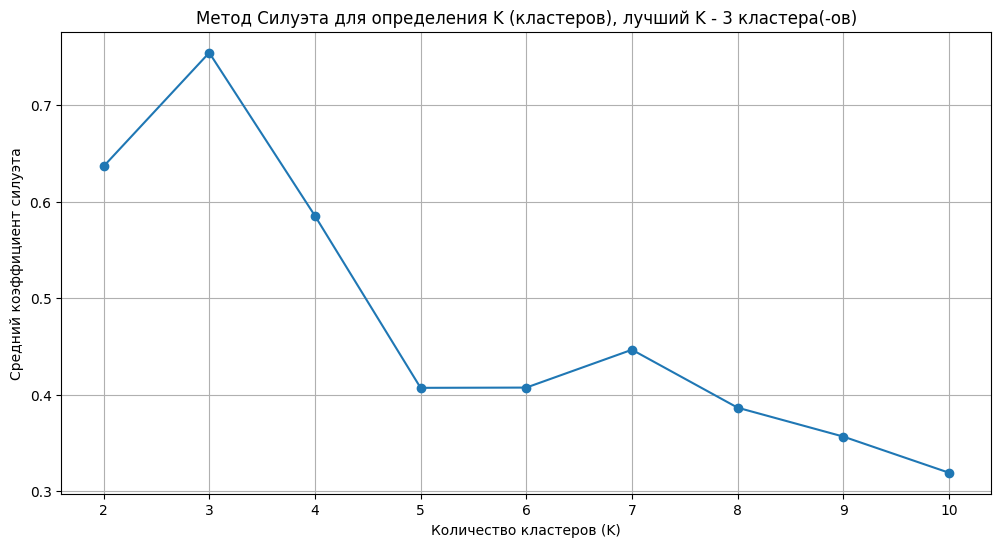

In [195]:
visualise_silhouette_score(calcilate_silhouette_score(KMeans, test_lists))

сделаем метрику силуэта для новых данных

In [196]:
# --- НОВАЯ ГЛАВНАЯ ФУНКЦИЯ для расчета среднего силуэта для внешних данных ---
def calculate_silhouette_for_external_data(X_new, labels_new, X_train, labels_train):
    """
    Вычисляет средний коэффициент силуэта для набора новых (внешних) точек данных,
    присвоенных кластерам, которые были обучены на X_train.

    Параметры:
    X_new (list или numpy.ndarray): Новые точки данных (одна или несколько).
    labels_new (list или numpy.ndarray): Метки кластеров, предсказанные для X_new.
                                        Должны быть в том же порядке, что и X_new.
    X_train (list или numpy.ndarray): Исходные обучающие данные, на которых была обучена модель.
    labels_train (numpy.ndarray): Метки кластеров для X_train, полученные после обучения.

    Возвращает:
    float: Средний коэффициент силуэта для X_new.
    """
    X_new_np = np.asarray(X_new, dtype=float)
    labels_new_np = np.asarray(labels_new, dtype=int)
    X_train_np = np.asarray(X_train, dtype=float)
    labels_train_np = np.asarray(labels_train, dtype=int)

    if X_new_np.ndim == 1: # Если X_new_np - одна точка, преобразуем в 2D массив (1, D)
        X_new_np = X_new_np[np.newaxis, :]
        labels_new_np = labels_new_np[np.newaxis] # То же для меток

    if X_new_np.shape[0] == 0:
        return 0.0 # Нет точек для оценки

    # Проверка, что в обучающих данных есть хотя бы 2 кластера
    if len(np.unique(labels_train_np)) <= 1:
        print("Предупреждение: В обучающих данных менее 2 кластеров. Коэффициент силуэта не определен.")
        return 0.0
    
    # Список для хранения индивидуальных коэффициентов силуэта для каждой новой точки
    silhouette_scores_for_new_samples = []

    # Проходимся по каждой новой точке
    for i in range(X_new_np.shape[0]):
        current_new_point = X_new_np[i]
        current_assigned_label = labels_new_np[i]

        # Шаг 1: Вычисление a(i) - среднего расстояния до точек в том же кластере (из обучающих данных)
        points_in_assigned_cluster = X_train_np[labels_train_np == current_assigned_label]
        
        if len(points_in_assigned_cluster) == 0:
            # Если кластер пуст в обучающих данных, a_i не определено.
            # Это очень редкий случай, но может произойти, если кластер "исчез"
            # после обучения. В этом случае силуэт не имеет смысла.
            silhouette_scores_for_new_samples.append(0.0) # Или np.nan
            continue # Переходим к следующей точке

        distances_to_assigned_cluster = [
            euclidean_distance(current_new_point, p) 
            for p in points_in_assigned_cluster 
        ]
        a_i = np.mean(distances_to_assigned_cluster)

        # Шаг 2: Вычисление b(i) - минимального среднего расстояния до точек в соседних кластерах (из обучающих данных)
        b_i = float('inf')
        unique_labels_train = np.unique(labels_train_np)
        
        for cluster_label in unique_labels_train:
            if cluster_label == current_assigned_label:
                continue # Пропускаем свой кластер
            
            points_in_other_cluster = X_train_np[labels_train_np == cluster_label]
            if len(points_in_other_cluster) > 0:
                distances_to_other_cluster = [euclidean_distance(current_new_point, p) for p in points_in_other_cluster]
                avg_distance_to_other_cluster = np.mean(distances_to_other_cluster)
                b_i = min(b_i, avg_distance_to_other_cluster)
            
        if b_i == float('inf'): # Это произойдет, если нет других кластеров для сравнения
            silhouette_scores_for_new_samples.append(0.0) # Силуэт не определен
            continue

        # Шаг 3: Вычисление коэффициента силуэта s(i)
        if max(a_i, b_i) == 0:
            current_silhouette = 0.0
        else:
            current_silhouette = (b_i - a_i) / max(a_i, b_i)
        
        silhouette_scores_for_new_samples.append(current_silhouette)
    
    if not silhouette_scores_for_new_samples:
        return 0.0 # Если не удалось посчитать силуэт ни для одной точки
    
    return np.mean(silhouette_scores_for_new_samples)

In [197]:
# --- 3. Подготовка НОВЫХ (внешних) данных ---
# Эти данные не использовались при обучении модели
new_data_point1 = [1.2, 2.2, 3.1, 4.0, 5.2]  # Очень похожа на кластер 1

# Объединяем новые точки в один массив (или список списков)
X_new_data = np.array([
    new_data_point1
])

In [198]:
# --- 4. Предсказание кластеров для НОВЫХ данных ---
labels_new_data = my_kmeans.predict(X_new_data)
print(f"\nНовые точки:\n{X_new_data}")
print(f"Предсказанные метки для новых точек: {labels_new_data}")


Новые точки:
[[1.2 2.2 3.1 4.  5.2]]
Предсказанные метки для новых точек: [0]


In [199]:
X_train_data = test_lists
labels_train_data = my_labels
calculate_silhouette_for_external_data(X_new_data, labels_new_data, X_train_data, labels_train_data)

np.float64(0.7273344488823413)

к-средних для косинусной метрики

In [200]:
class KMeansCosine:
    def __init__(self, n_clusters=3, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.labels = None 
        self.inertia_ = None 

    def _initialize_centroids(self, X_np):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        indices = np.random.choice(X_np.shape[0], self.n_clusters, replace=False)
        self.centroids = X_np[indices]

    def _assign_clusters(self, X_np):
        distances = np.zeros((X_np.shape[0], self.n_clusters))
        for i in range(X_np.shape[0]):
            for k in range(self.n_clusters):
                dist = calculate_cosine_distance_manual(X_np[i], self.centroids[k]) 
                distances[i, k] = dist if not np.isnan(dist) else float('inf')
        # Использование axis=1 при argmin для 2D массива
        self.labels = np.argmin(distances, axis=1) 

    def _update_centroids(self, X_np):
        new_centroids = np.zeros_like(self.centroids)
        for k in range(self.n_clusters):
            points_in_cluster = X_np[self.labels == k]
            if len(points_in_cluster) > 0:
                # Избегаем деления на ноль для нулевых векторов при нормализации
                norms = np.linalg.norm(points_in_cluster, axis=1, keepdims=True)
                
                # Заменяем нулевые нормы на 1, чтобы избежать деления на ноль; 
                # при этом соответствующие точки останутся нулями после деления
                safe_norms = np.where(norms == 0, 1, norms)
                normalized_points = points_in_cluster / safe_norms
                
                new_centroid = np.mean(normalized_points, axis=0)
                
                # Дополнительная обработка для центроида: 
                # если он становится нулевым или NaN, делаем его нулями
                centroid_norm = np.linalg.norm(new_centroid)
                if centroid_norm > 0 and not np.isnan(centroid_norm):
                    new_centroids[k] = new_centroid / centroid_norm
                else:
                    new_centroids[k] = np.zeros_like(new_centroid) # Если норма 0 или NaN, сбросить в нули
            else:
                new_centroids[k] = self.centroids[k] # Кластер пуст, сохраняем старый центроид
        self.centroids = new_centroids

    def _calculate_wcss(self, X_np):
        total_cosine_distance = 0
        for i in range(X_np.shape[0]):
            current_point = X_np[i]
            assigned_label = self.labels[i]
            centroid = self.centroids[assigned_label]
            
            dist = calculate_cosine_distance_manual(current_point, centroid)
            if not np.isnan(dist):
                total_cosine_distance += dist
        self.inertia_ = total_cosine_distance
        return total_cosine_distance

    def fit(self, X):
        X_np = np.asarray(X, dtype=float)

        if X_np.ndim != 2:
            raise ValueError("Входные данные X должны быть 2-мерным массивом (N точек, D измерений).")
        if self.n_clusters > X_np.shape[0]:
            raise ValueError("Количество кластеров (n_clusters) не может быть больше количества точек данных.")
        if self.n_clusters <= 0:
            raise ValueError("Количество кластеров (n_clusters) должно быть положительным.")
        if self.n_clusters == 1 and X_np.shape[0] > 1:
             print("Предупреждение: для K=1 коэффициент силуэта обычно не вычисляется или равен 0.")

        self._initialize_centroids(X_np)
        
        for i in range(self.max_iter):
            old_labels = np.copy(self.labels)
            self._assign_clusters(X_np)
            self._update_centroids(X_np)
            if np.array_equal(old_labels, self.labels):
                break
        
        self._calculate_wcss(X_np)
        return self

    def predict(self, X):
        if self.centroids is None:
            raise RuntimeError("Модель не обучена. Используйте fit() перед predict().")
        
        X_np = np.asarray(X, dtype=float)
        
        original_ndim = X_np.ndim 
        if X_np.ndim == 1: 
            X_np = X_np[np.newaxis, :]

        if X_np.ndim != 2:
            raise ValueError("Входные данные X должны быть 2-мерным массивом (N точек, D измерений) или 1-мерным для одной точки.")
        
        distances = np.zeros((X_np.shape[0], self.n_clusters))
        for i in range(X_np.shape[0]):
            for k in range(self.n_clusters):
                dist = calculate_cosine_distance_manual(X_np[i], self.centroids[k]) 
                distances[i, k] = dist if not np.isnan(dist) else float('inf')
        
        if original_ndim == 1:
            return np.argmin(distances, axis=1)[0] 
        return np.argmin(distances, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels

проверим ее на тестовых данных

In [201]:
test_lists

[[0.82, 2.15, 2.98, 3.84, 4.71],
 [1.11, 1.92, 3.07, 4.23, 5.26],
 [1.02, 2.03, 2.94, 4.17, 5.25],
 [1.07, 2.03, 2.99, 4.27, 4.72],
 [1.23, 1.77, 3.18, 4.24, 4.92],
 [0.75, 1.72, 2.94, 4.03, 4.99],
 [0.72, 1.96, 2.94, 4.05, 5.2],
 [1.07, 2.24, 3.03, 4.28, 5.15],
 [1.21, 2.0, 3.27, 3.75, 4.78],
 [1.26, 1.88, 2.71, 3.75, 5.22],
 [1.74, 3.23, 3.92, 4.73, 5.94],
 [1.72, 3.1, 3.95, 4.85, 6.26],
 [2.29, 2.91, 4.05, 5.25, 5.76],
 [1.72, 2.92, 4.08, 5.1, 5.91],
 [2.12, 3.11, 3.83, 4.86, 6.16],
 [1.85, 3.29, 4.16, 5.15, 6.25],
 [1.88, 2.88, 3.85, 4.89, 5.9],
 [1.7, 2.94, 4.03, 5.3, 6.01],
 [1.72, 2.85, 3.74, 5.27, 5.7],
 [2.03, 3.27, 3.97, 4.96, 6.01],
 [3.04, 4.24, 5.14, 5.8, 6.78],
 [3.17, 3.82, 4.88, 6.01, 7.12],
 [3.14, 3.78, 5.2, 5.72, 6.82],
 [3.0, 3.92, 4.83, 5.91, 7.14],
 [3.13, 4.01, 5.2, 6.22, 7.16],
 [2.76, 3.82, 5.18, 6.09, 6.87],
 [3.12, 4.27, 4.86, 5.81, 7.13],
 [3.14, 3.98, 4.98, 5.93, 7.08],
 [3.1, 3.89, 4.79, 5.88, 7.18],
 [3.06, 4.24, 4.75, 5.74, 6.98]]

In [202]:
my_kmeans_cosine = KMeansCosine(n_clusters=3, max_iter=100, random_state=0)
my_labels_cosine = my_kmeans_cosine.fit_predict(test_lists)

print("\nМетки кластеров, полученные моей реализацией K-Means с косинусной метрикой:")
print(my_labels_cosine)

print("\nНайденные центроиды моей реализации:")
print(my_kmeans_cosine.centroids)


Метки кластеров, полученные моей реализацией K-Means с косинусной метрикой:
[0 0 0 0 0 0 0 0 2 0 2 2 1 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1]

Найденные центроиды моей реализации:
[[0.13426233 0.26295546 0.39782404 0.5473232  0.67453792]
 [0.26223256 0.34115754 0.42917885 0.5134762  0.60579974]
 [0.19072408 0.31885492 0.4202091  0.52813045 0.6375409 ]]


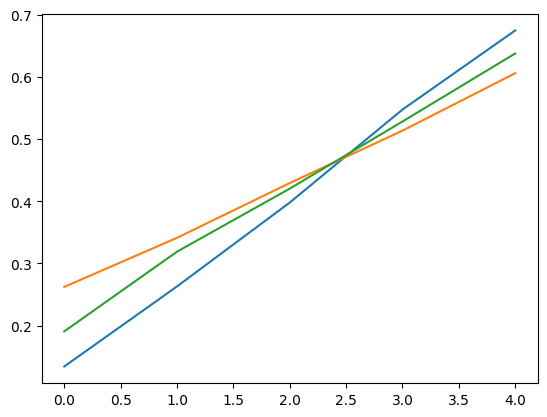

In [203]:
for i in my_kmeans_cosine.centroids:
    plt.plot(i)

plt.show()

Посмотрим по метрикам силуэта как было бы лучше обучать косинусную модель

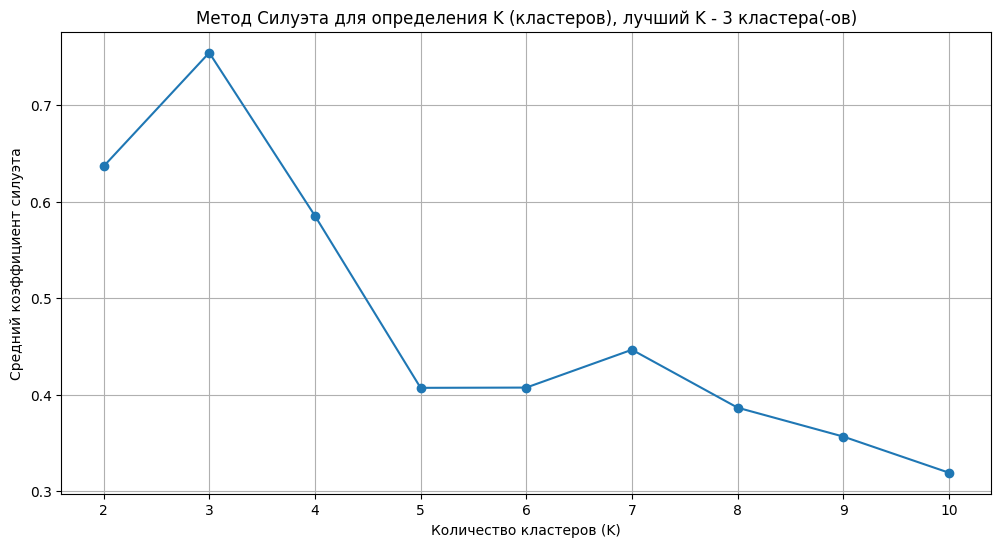

In [204]:
visualise_silhouette_score(calcilate_silhouette_score(KMeans, test_lists))

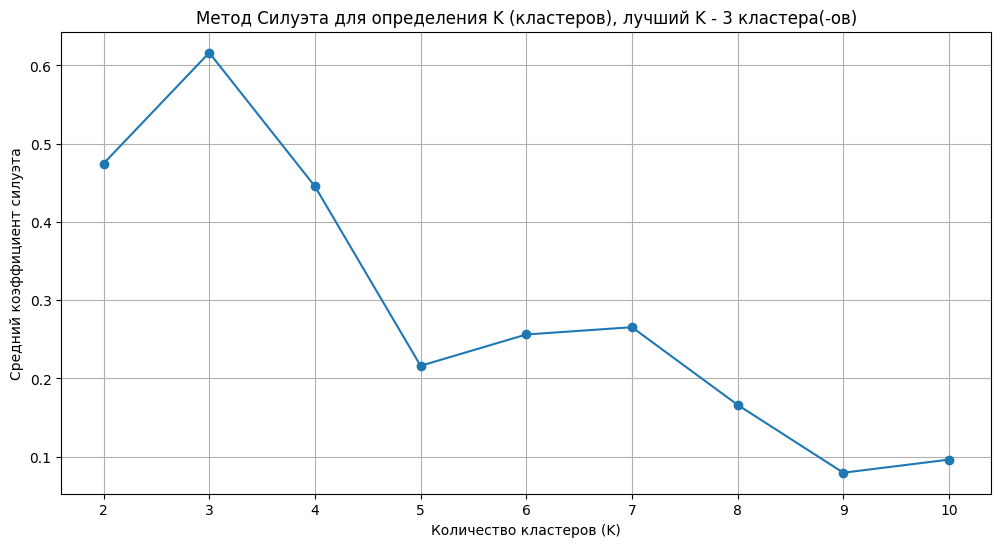

In [205]:

visualise_silhouette_score(calcilate_silhouette_score(KMeansCosine, test_lists))

Посмотрим силуэт для новых данных

Это для обычной Kmeans

In [206]:
X_train_data = test_lists
labels_train_data = my_labels
calculate_silhouette_for_external_data(X_new_data, labels_new_data, X_train_data, labels_train_data)

np.float64(0.7273344488823413)

Это для косинусной

In [207]:
new_data_point2 = [1.2, 2.2, 3.1, 4.0, 5.2]  # Очень похожа на кластер 1

# Объединяем новые точки в один массив (или список списков)
X_new_data_cosine = np.array([
    new_data_point1
])

# --- 4. Предсказание кластеров для НОВЫХ данных ---
labels_new_data_cosine = my_kmeans_cosine.predict(X_new_data_cosine)
print(f"\nНовые точки:\n{X_new_data_cosine}")
print(f"Предсказанные метки для новых точек: {labels_new_data_cosine}")


Новые точки:
[[1.2 2.2 3.1 4.  5.2]]
Предсказанные метки для новых точек: [0]


In [208]:
X_train_data_cosine = test_lists
labels_train_data_cosine = my_labels_cosine
calculate_silhouette_for_external_data(X_new_data_cosine, labels_new_data_cosine, X_train_data_cosine, labels_train_data_cosine)

np.float64(0.7051513651655003)

Функция которая берет данные с обучающей выборки, нормализует в них данные
Потом берет метки для этих данных, группирует данные по меткам
И создает средние 

In [209]:
def create_conversations_normalized_from_data(data, labels):

    flattened = [x for sublist in data for x in sublist]
    max_value = max(flattened)

    normalised = []
    for element in data:
        normalised.append([x / max_value for x in element])

    dict_of_labels = {}
    for element in labels:
        if element not in dict_of_labels:
            dict_of_labels[int(element)] = []

    for label_index in range(len(labels)):
        dict_of_labels[int(labels[label_index])].append(normalised[label_index])

    for key in dict_of_labels:
        buffer = [0 for i in range(len(dict_of_labels[key][0]))]
        for element in dict_of_labels[key]:
            for i in range(len(element)):
                buffer[i] += element[i]
        buffer = [x / len(dict_of_labels[key]) for x in buffer]
        dict_of_labels[key] = buffer

    return dict_of_labels

Такая же функция только без нормализации, можно сравнить с центроидами

In [210]:
def create_conversations_from_data(data, labels):


    normalised = []
    for element in data:
        normalised.append([x for x in element])

    dict_of_labels = {}
    for element in labels:
        if element not in dict_of_labels:
            dict_of_labels[int(element)] = []

    for label_index in range(len(labels)):
        dict_of_labels[int(labels[label_index])].append(normalised[label_index])

    for key in dict_of_labels:
        buffer = [0 for i in range(len(dict_of_labels[key][0]))]
        for element in dict_of_labels[key]:
            for i in range(len(element)):
                buffer[i] += element[i]
        buffer = [x / len(dict_of_labels[key]) for x in buffer]
        dict_of_labels[key] = buffer

    return dict_of_labels

In [211]:
conversations_normalized = create_conversations_normalized_from_data(test_lists, my_labels)

Функция отрисовки графиков для кластеров

In [212]:
def vizualize_conversations(conversations_dict):

    conversations_dict_keys = sorted(list(conversations_dict.keys()))

    for i in conversations_dict_keys:
        plt.figure(figsize=(12, 6))

        # Строим график
        plt.plot(conversations_dict[i], linewidth=1, color='red')

        # Настраиваем внешний вид графика
        plt.title(f"Для кластера с номером - {i}")
        plt.xlabel('Время')
        plt.ylabel('Нормализованное значение')

        # Поворачиваем метки на оси X для лучшей читаемости
        plt.xticks(rotation=45)

        # Добавляем сетку
        plt.grid(True, linestyle='--', alpha=0.7)

        # Настраиваем расположение элементов
        plt.tight_layout()

        # Показываем график
        plt.show() 
    


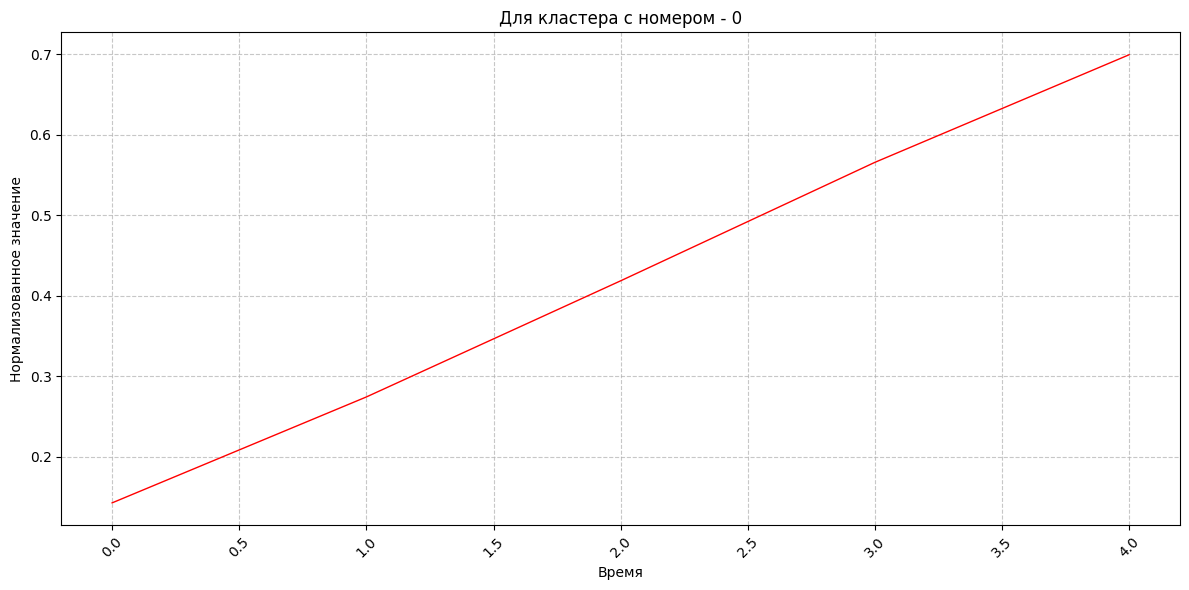

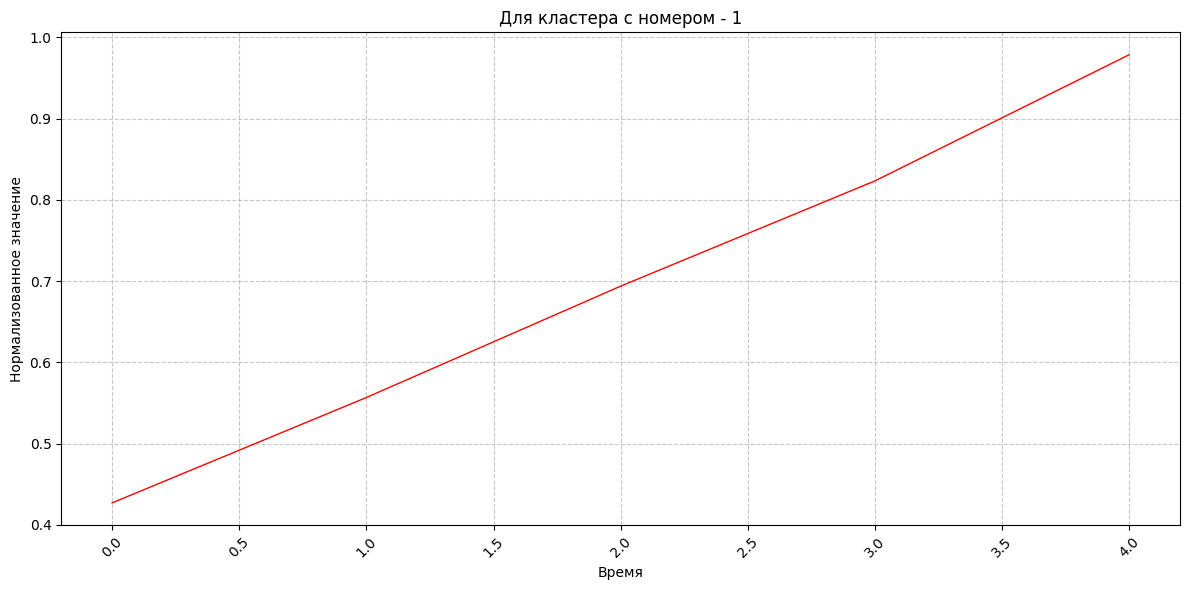

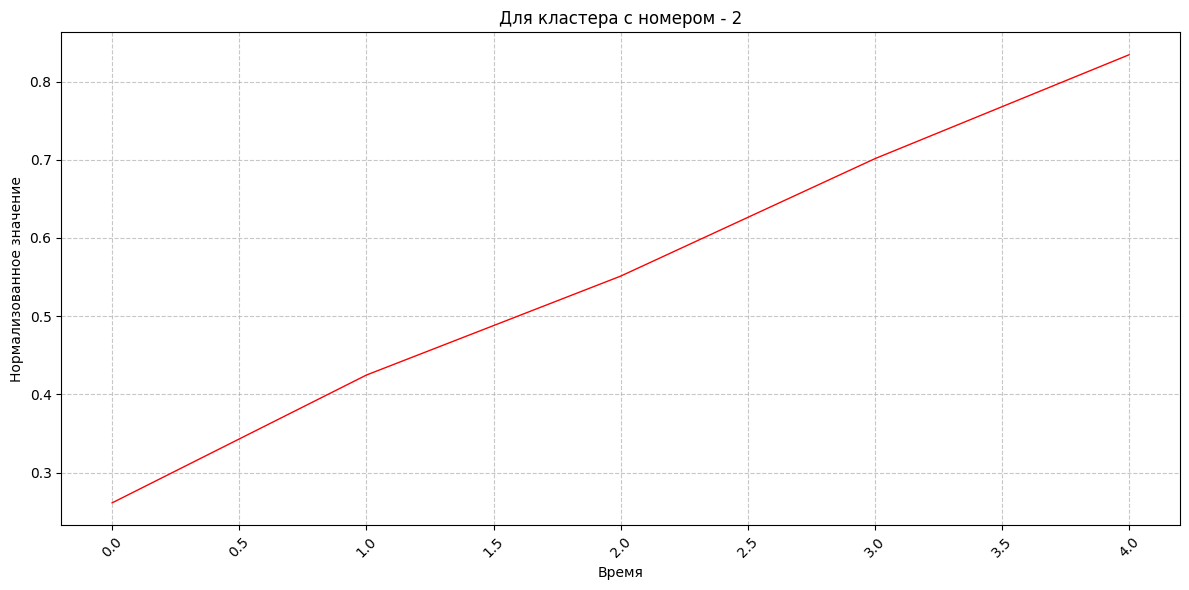

In [213]:
vizualize_conversations(create_conversations_normalized_from_data(test_lists, my_labels))

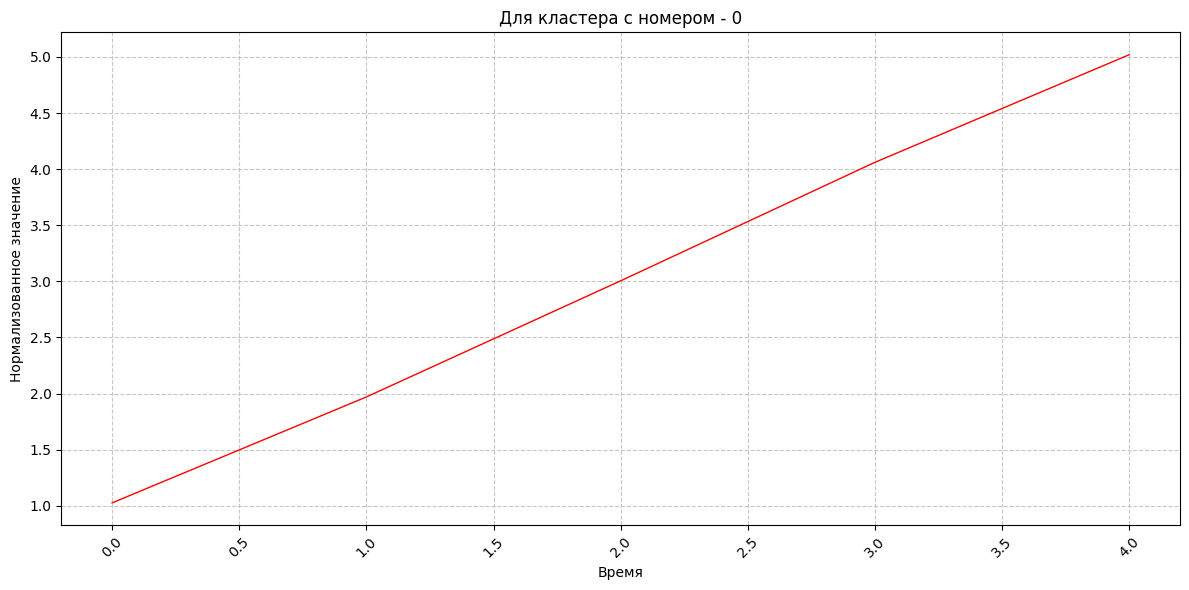

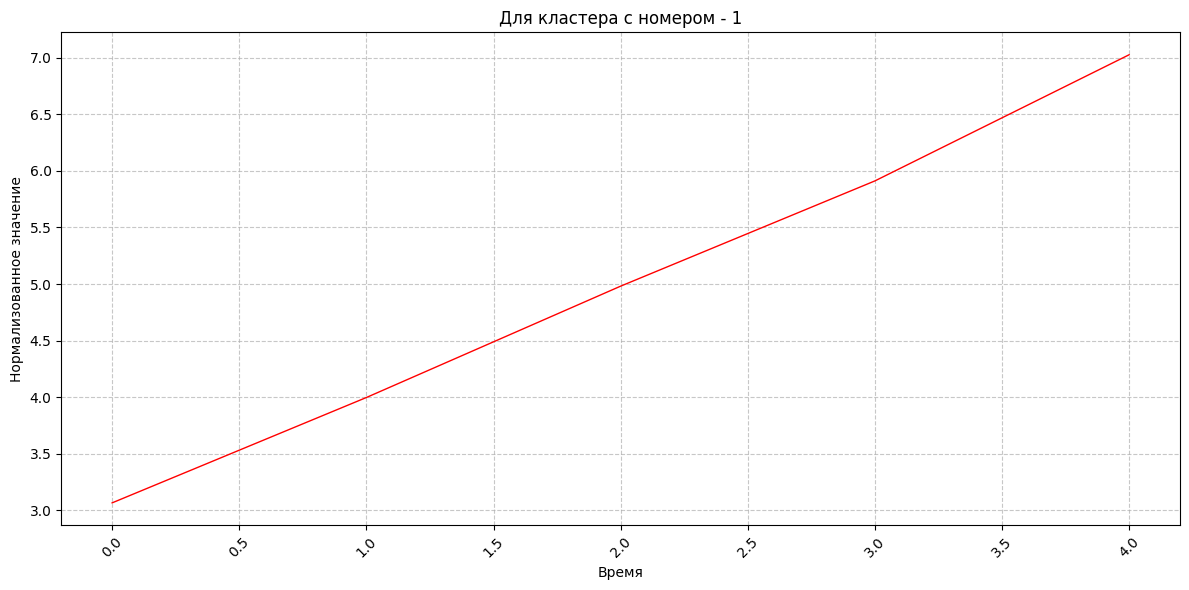

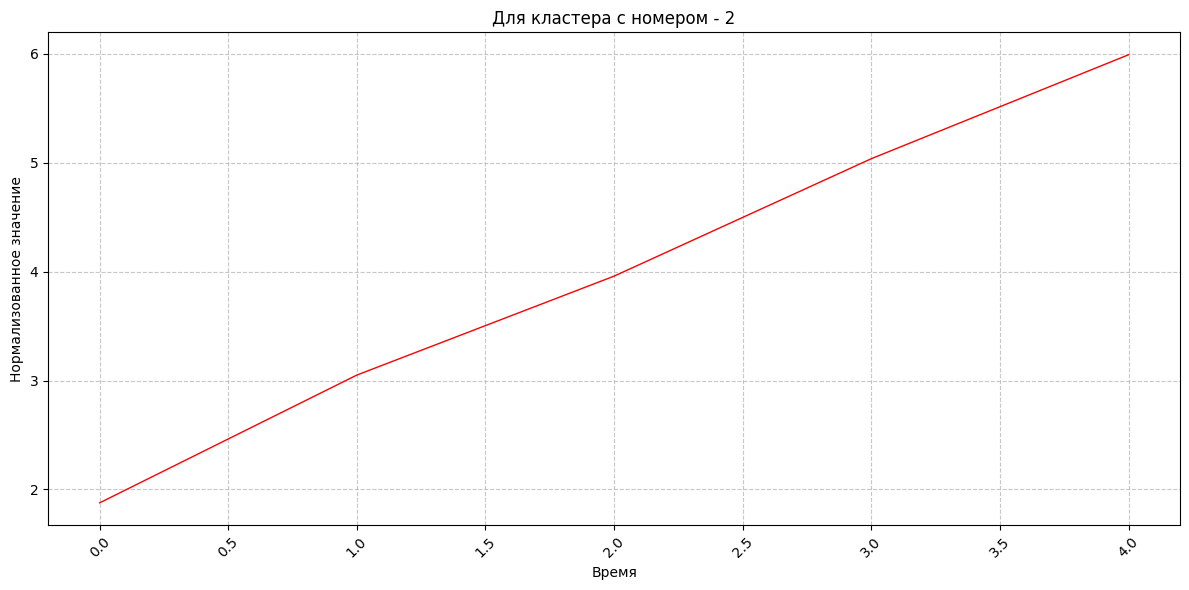

In [214]:
vizualize_conversations(create_conversations_from_data(test_lists, my_labels))

Функция отрисовки центроидов

In [215]:
def vizualize_centroids(model):
    for i in range(len(model.centroids)):
        plt.figure(figsize=(12, 6))

        # Строим график
        plt.plot(model.centroids[i], linewidth=1, color='red')

        # Настраиваем внешний вид графика
        plt.title(f"Для кластера с номером - {i}")
        plt.xlabel('Время')
        plt.ylabel('Нормализованное значение')

        # Поворачиваем метки на оси X для лучшей читаемости
        plt.xticks(rotation=45)

        # Добавляем сетку
        plt.grid(True, linestyle='--', alpha=0.7)

        # Настраиваем расположение элементов
        plt.tight_layout()

        # Показываем график
        plt.show() 

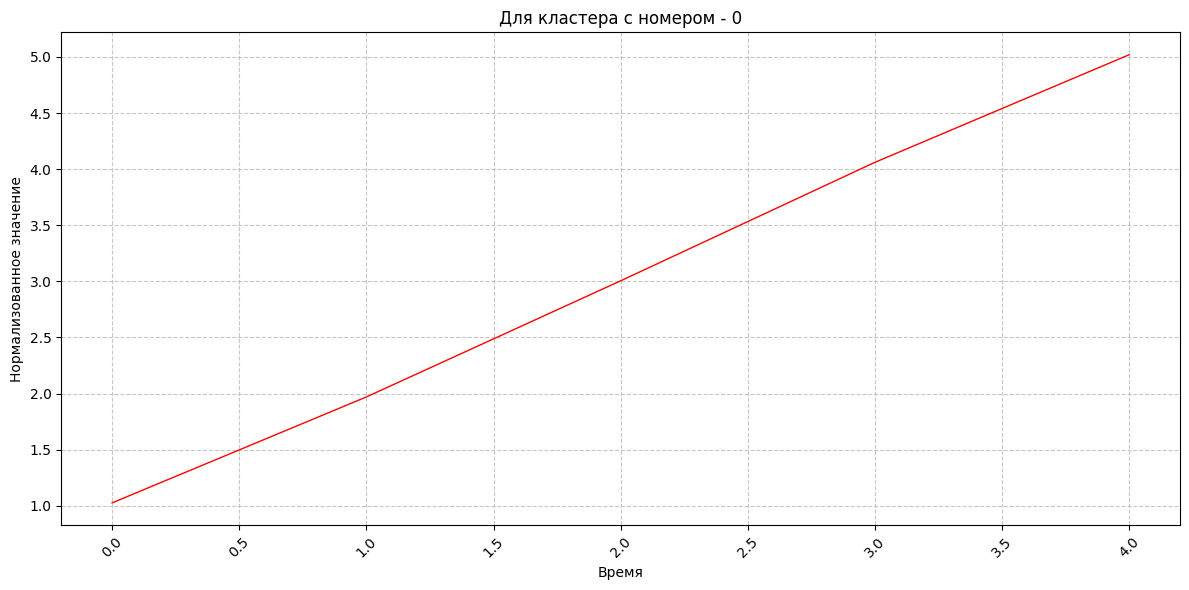

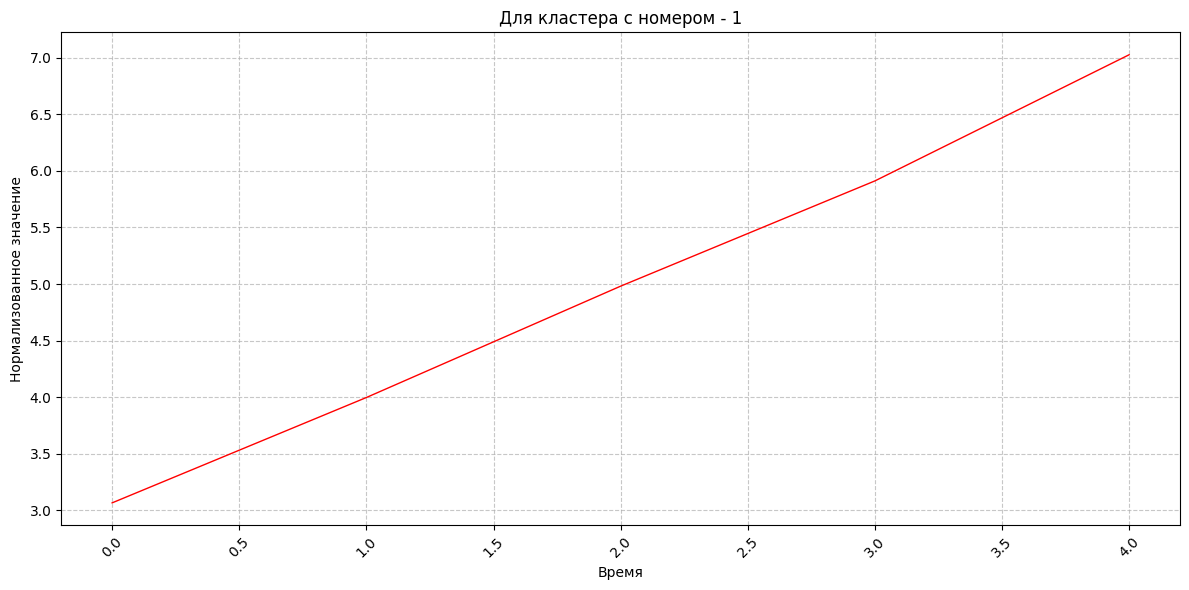

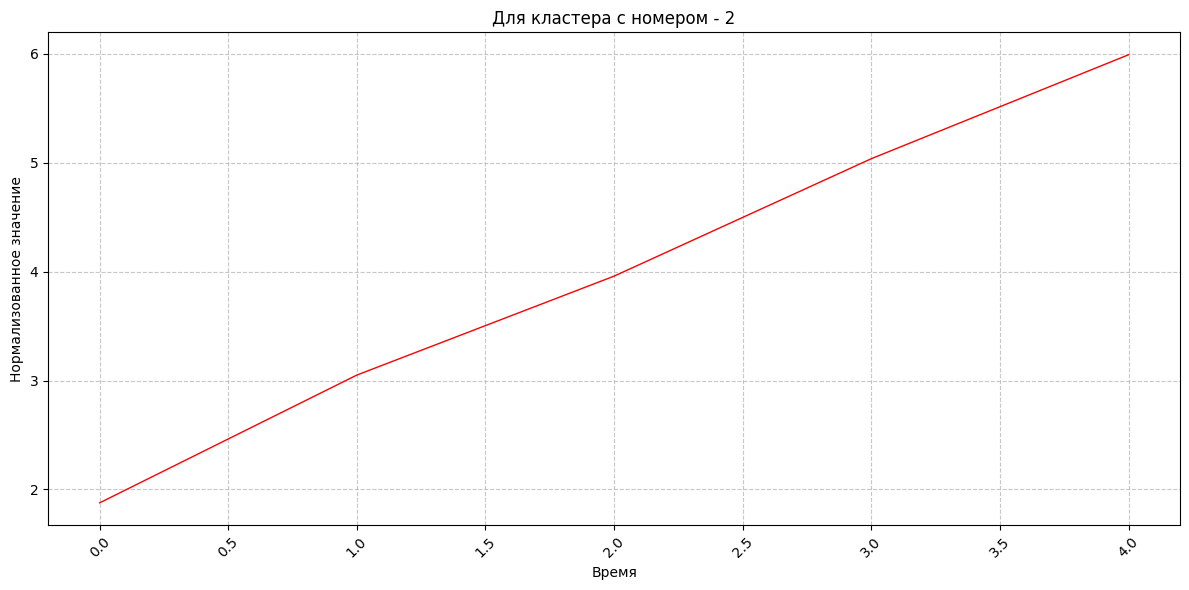

In [216]:
vizualize_centroids(my_kmeans)

Функция для парсинга данных временнорго ряда с изменением длины отрезка ряда

In [219]:
DATA[0].keys()


dict_keys(['TICKER', 'DATES', 'CLOSE_PRICES', 'VOLUMES'])

In [223]:
def parse_data_of_time_serie(data, window_size):
    result = []
    for i in range(len(data) - window_size):
        result.append(data[i:i+window_size])
    return result

Функция для создания объекта из разбитых данных и для их средних

In [233]:
def create_train_data_with_sma(data, window_size = 7, sma_window_size = 10):
    sma_array = calculate_sma(data, sma_window_size)
    data_array = data[sma_window_size-1::]

    sma_array_parsed = parse_data_of_time_serie(sma_array, window_size)
    data_array_parsed = parse_data_of_time_serie(data_array, window_size)

    return {
        "data": data_array,
        "sma": sma_array,
        "data_parsed": data_array_parsed,
        "sma_parsed": sma_array_parsed
    }

In [239]:
result_sma_and_data_for_ALRS_CLOSE_PRICES = create_train_data_with_sma(DATA[0]["CLOSE_PRICES"], window_size = 7, sma_window_size = 10)

Тестовые и обучающие выборки (как пример)

In [228]:
from sklearn.model_selection import train_test_split

# Исходные данные - список списков (матрица признаков)
data = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
    [10, 11, 12],
    [13, 14, 15],
    [16, 17, 18]
]

# Разбиваем на train (70%) и test (30%)
train_data, test_data = train_test_split(
    data,
    test_size=0.3,        # 30% в тестовую выборку
    random_state=42       # для воспроизводимости
)

print("Обучающая выборка:")
for row in train_data:
    print(row)
    
print("\nТестовая выборка:")
for row in test_data:
    print(row)

Обучающая выборка:
[16, 17, 18]
[7, 8, 9]
[13, 14, 15]
[10, 11, 12]

Тестовая выборка:
[1, 2, 3]
[4, 5, 6]


Проведем кластеризацтю для ALRS через косинусную метрику (стандартная угловая метрика кластеризации)

проанализируем метрики силуэта для отрезков с изменяюшейся длиной окна

In [276]:
buffer_of_silhouette_scores_cosine = {
    "window_size": [],
    "silhouette_score": []
}

for window_size in range(3, 50):
    result_data_for_ALRS_CLOSE_PRICES_BUFFER = parse_data_of_time_serie(DATA[0]["CLOSE_PRICES"], window_size = window_size)
    
    buffer_of_silhouette_scores_cosine["window_size"].append(window_size)

    
    calculated = calcilate_silhouette_score(KMeansCosine, result_data_for_ALRS_CLOSE_PRICES_BUFFER, max_iter_in_model = 100, max_clusters_to_check = 20, random_state_in_model = 0)
    buffer_of_silhouette_scores_cosine["silhouette_score"].append(calculated)

    print(f"window_size: {window_size}, silhouette_score: {calculated['best_silhouette_score']}")




window_size: 3, silhouette_score: 0.0064060975878431955
window_size: 4, silhouette_score: 0.012039473475010313
window_size: 5, silhouette_score: -0.01748330514899732
window_size: 6, silhouette_score: 0.004757554998179291
window_size: 7, silhouette_score: -0.011096347728253424
window_size: 8, silhouette_score: -0.0009116456021894117
window_size: 9, silhouette_score: 0.0094992845677387
window_size: 10, silhouette_score: 0.014403457375250013
window_size: 11, silhouette_score: 0.028958847866780133
window_size: 12, silhouette_score: 0.03640393245989392
window_size: 13, silhouette_score: 0.04142238020617754
window_size: 14, silhouette_score: 0.04654619523231743
window_size: 15, silhouette_score: 0.04970660294354914
window_size: 16, silhouette_score: 0.05189972320983258
window_size: 17, silhouette_score: 0.05293069240914789
window_size: 18, silhouette_score: 0.05597477862886826
window_size: 19, silhouette_score: 0.08404042350302561
window_size: 20, silhouette_score: 0.09774602683421724
window

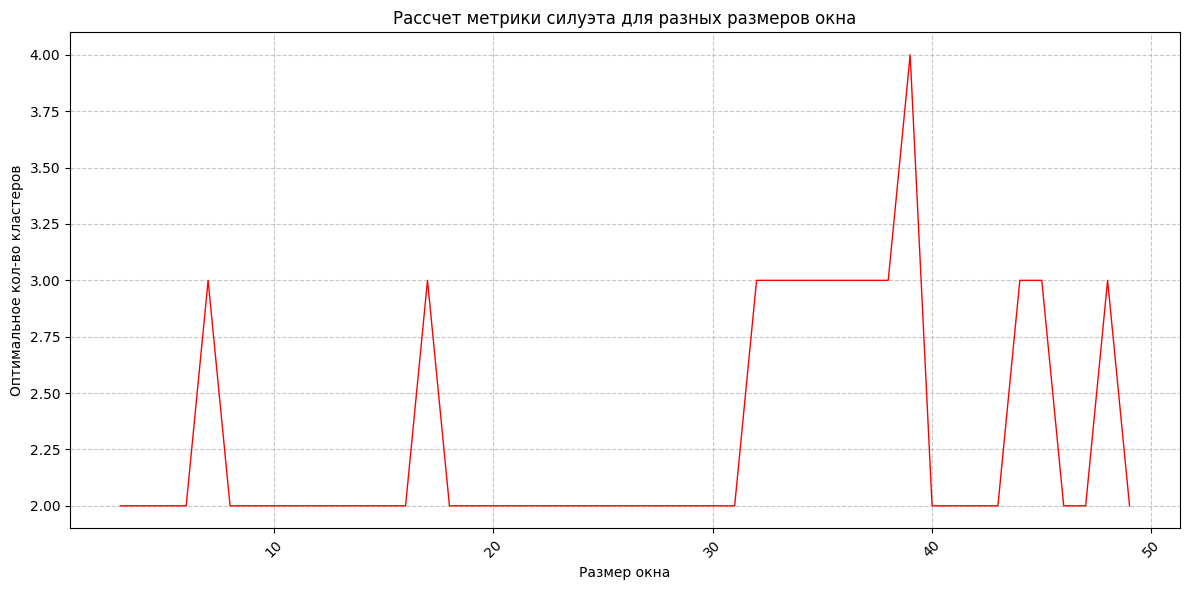

In [277]:
plt.figure(figsize=(12, 6))

# Строим график
plt.plot(buffer_of_silhouette_scores_cosine["window_size"], [buffer_of_silhouette_scores_cosine['silhouette_score'][i]['best_count_of_clusters'] for i in range(len(buffer_of_silhouette_scores_cosine["window_size"]))], linewidth=1, color='red')

# Настраиваем внешний вид графика
plt.title(f"Рассчет метрики силуэта для разных размеров окна")
plt.xlabel('Размер окна')
plt.ylabel('Оптимальное кол-во кластеров')

# Поворачиваем метки на оси X для лучшей читаемости
plt.xticks(rotation=45)

# Добавляем сетку
plt.grid(True, linestyle='--', alpha=0.7)

# Настраиваем расположение элементов
plt.tight_layout()

# Показываем график
plt.show() 


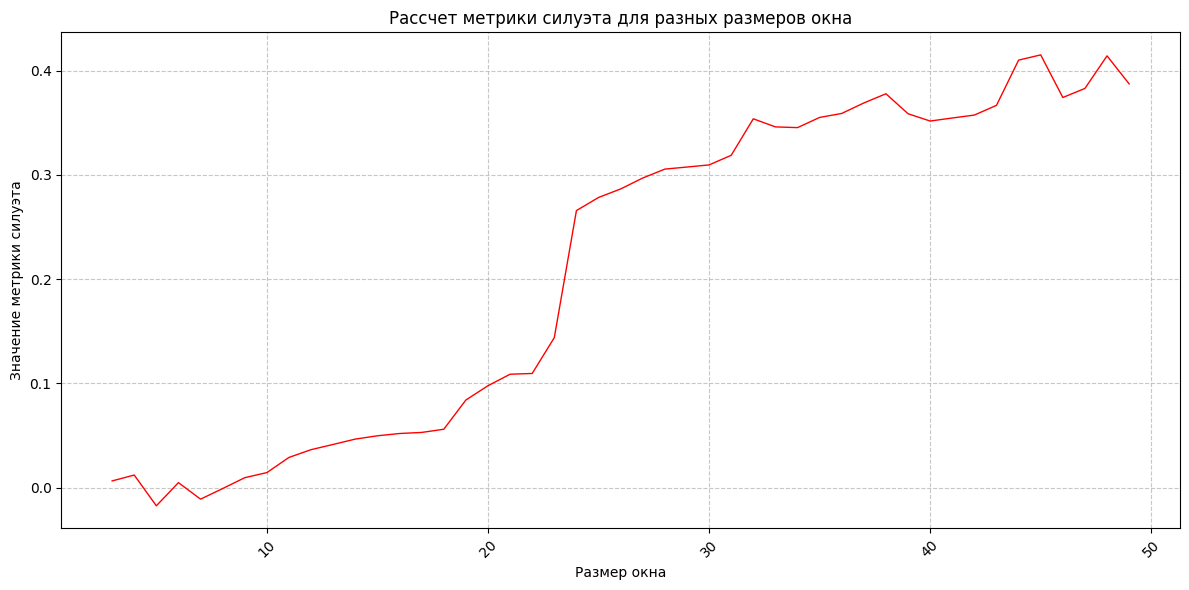

In [278]:
plt.figure(figsize=(12, 6))

# Строим график
plt.plot(buffer_of_silhouette_scores_cosine["window_size"], [buffer_of_silhouette_scores_cosine['silhouette_score'][i]['best_silhouette_score'] for i in range(len(buffer_of_silhouette_scores_cosine["window_size"]))], linewidth=1, color='red')

# Настраиваем внешний вид графика
plt.title(f"Рассчет метрики силуэта для разных размеров окна")
plt.xlabel('Размер окна')
plt.ylabel('Значение метрики силуэта')

# Поворачиваем метки на оси X для лучшей читаемости
plt.xticks(rotation=45)

# Добавляем сетку
plt.grid(True, linestyle='--', alpha=0.7)

# Настраиваем расположение элементов
plt.tight_layout()

# Показываем график
plt.show() 

In [280]:
max([buffer_of_silhouette_scores_cosine['silhouette_score'][i]['best_silhouette_score'] for i in range(len(buffer_of_silhouette_scores_cosine["window_size"]))])

0.41522258518065464

In [283]:
buffer_of_silhouette_scores_cosine

{'window_size': [3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 'silhouette_score': [{'silhouette_scores': [0.0064060975878431955,
    -0.06399866100403316,
    -0.07335232597464973,
    -0.0790583922390733,
    -0.07048181719580081,
    -0.17717099422424085,
    -0.17954349116546134,
    -0.15792132224555122,
    -0.17141603288126436,
    -0.2033152098251953,
    -0.24003298660978922,
    -0.2219978828850644,
    -0.21639158112809737,
    -0.2368907593756445,
    -0.2578618162225201,
    -0.293721898560043,
    -0.2733431700809672,
    -0.3190564694558059,
    -0.31646773027704417],
   'best_count_of_clusters': 2,
   'best_silhouette_score': 0.0064060975878431955,
   'model': <__main__.KMeansCosine at 0x13830151540>},
  {'silhouette_scores': [0.0120394734750103

попробуем для обычного евклидового расстояния

In [285]:
buffer_of_silhouette_scores = {
    "window_size": [],
    "silhouette_score": []
}

for window_size in range(3, 50):
    result_data_for_ALRS_CLOSE_PRICES_BUFFER = parse_data_of_time_serie(DATA[0]["CLOSE_PRICES"], window_size = window_size)
    
    buffer_of_silhouette_scores["window_size"].append(window_size)

    
    calculated = calcilate_silhouette_score(KMeans, result_data_for_ALRS_CLOSE_PRICES_BUFFER, max_iter_in_model = 100, max_clusters_to_check = 20, random_state_in_model = 0)
    buffer_of_silhouette_scores["silhouette_score"].append(calculated)

    print(f"window_size: {window_size}, silhouette_score: {calculated['best_silhouette_score']}")

window_size: 3, silhouette_score: 0.6601522479511432
window_size: 4, silhouette_score: 0.6624838702062046
window_size: 5, silhouette_score: 0.6582501729516276
window_size: 6, silhouette_score: 0.6550581603018416
window_size: 7, silhouette_score: 0.6486098893561042
window_size: 8, silhouette_score: 0.6456277148291242
window_size: 9, silhouette_score: 0.6385718887363684
window_size: 10, silhouette_score: 0.6358058746687252
window_size: 11, silhouette_score: 0.6285841615660902
window_size: 12, silhouette_score: 0.6232061334964654
window_size: 13, silhouette_score: 0.5722920013491489
window_size: 14, silhouette_score: 0.5715976038283102
window_size: 15, silhouette_score: 0.6055126178826393
window_size: 16, silhouette_score: 0.6002819855075942
window_size: 17, silhouette_score: 0.5933717045163249
window_size: 18, silhouette_score: 0.5885885475707189
window_size: 19, silhouette_score: 0.582176222832393
window_size: 20, silhouette_score: 0.5584790583042402
window_size: 21, silhouette_score: 0

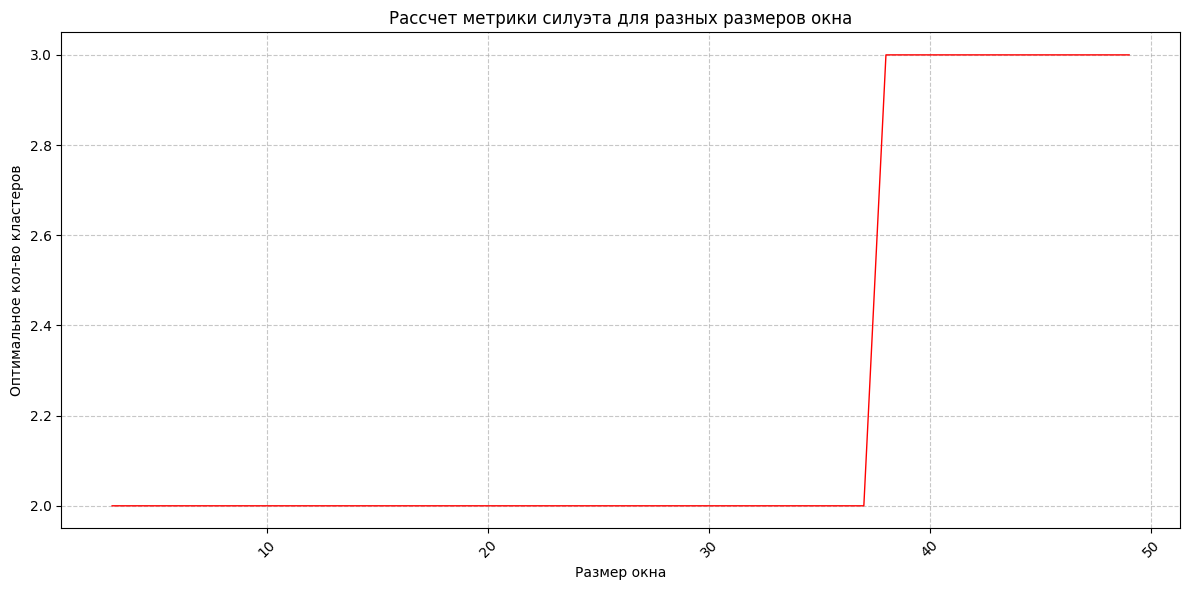

In [286]:
plt.figure(figsize=(12, 6))

# Строим график
plt.plot(buffer_of_silhouette_scores["window_size"], [buffer_of_silhouette_scores['silhouette_score'][i]['best_count_of_clusters'] for i in range(len(buffer_of_silhouette_scores["window_size"]))], linewidth=1, color='red')

# Настраиваем внешний вид графика
plt.title(f"Рассчет метрики силуэта для разных размеров окна")
plt.xlabel('Размер окна')
plt.ylabel('Оптимальное кол-во кластеров')

# Поворачиваем метки на оси X для лучшей читаемости
plt.xticks(rotation=45)

# Добавляем сетку
plt.grid(True, linestyle='--', alpha=0.7)

# Настраиваем расположение элементов
plt.tight_layout()

# Показываем график
plt.show() 

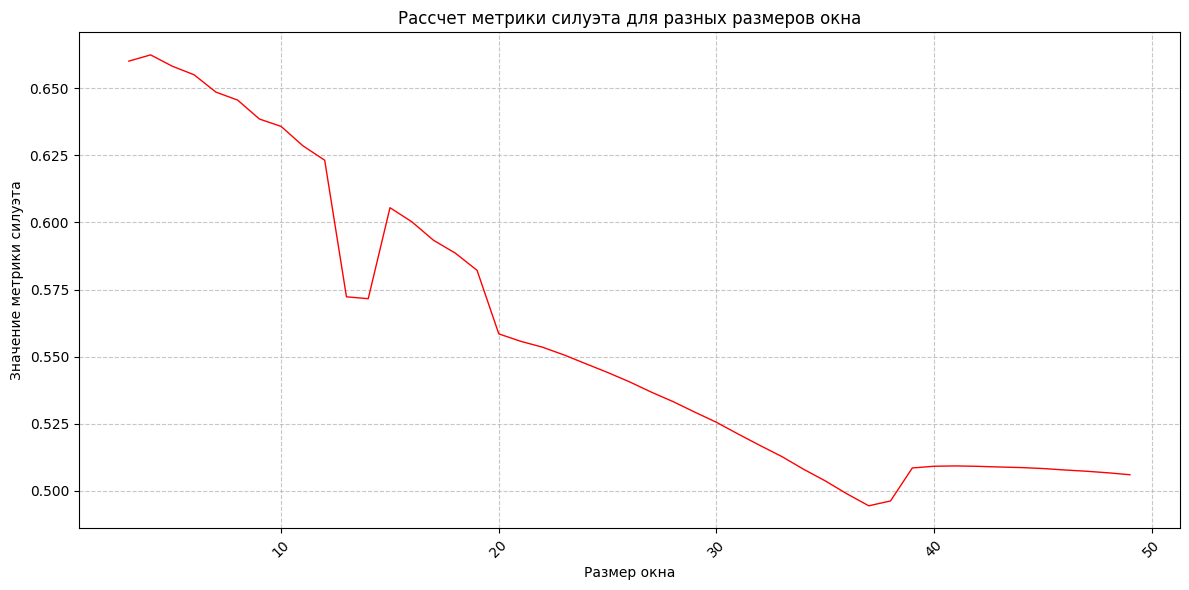

In [287]:
plt.figure(figsize=(12, 6))

# Строим график
plt.plot(buffer_of_silhouette_scores["window_size"], [buffer_of_silhouette_scores['silhouette_score'][i]['best_silhouette_score'] for i in range(len(buffer_of_silhouette_scores["window_size"]))], linewidth=1, color='red')

# Настраиваем внешний вид графика
plt.title(f"Рассчет метрики силуэта для разных размеров окна")
plt.xlabel('Размер окна')
plt.ylabel('Значение метрики силуэта')

# Поворачиваем метки на оси X для лучшей читаемости
plt.xticks(rotation=45)

# Добавляем сетку
plt.grid(True, linestyle='--', alpha=0.7)

# Настраиваем расположение элементов
plt.tight_layout()

# Показываем график
plt.show() 

In [274]:
max([buffer_of_silhouette_scores['silhouette_score'][i]['best_silhouette_score'] for i in range(len(buffer_of_silhouette_scores['window_size']))])

0.41522258518065464

In [284]:
buffer_of_silhouette_scores


{'window_size': [3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 'silhouette_score': [{'silhouette_scores': [0.0064060975878431955,
    -0.06399866100403316,
    -0.07335232597464973,
    -0.0790583922390733,
    -0.07048181719580081,
    -0.17717099422424085,
    -0.17954349116546134,
    -0.15792132224555122,
    -0.17141603288126436,
    -0.2033152098251953,
    -0.24003298660978922,
    -0.2219978828850644,
    -0.21639158112809737,
    -0.2368907593756445,
    -0.2578618162225201,
    -0.293721898560043,
    -0.2733431700809672,
    -0.3190564694558059,
    -0.31646773027704417],
   'best_count_of_clusters': 2,
   'best_silhouette_score': 0.0064060975878431955,
   'model': <__main__.KMeansCosine at 0x1382d0e02b0>},
  {'silhouette_scores': [0.0120394734750103

сделаем через дельта метрику

In [294]:
buffer_of_silhouette_scores_DELTA = {
    "window_size": [],
    "sma_window_size": [],
    "silhouette_score": []
}


for window_size in range(2, 20) :
    for sma_window_size in range(10, 50):
        result_sma_and_data_to_DELTA_METRIC = create_train_data_with_sma(DATA[0]["CLOSE_PRICES"], window_size = window_size, sma_window_size = sma_window_size)

        buffer_train_data = []
        for index in range(len(result_sma_and_data_to_DELTA_METRIC["data_parsed"])):
            buffer_train_data.append(delta_metric(result_sma_and_data_to_DELTA_METRIC["sma_parsed"][index], result_sma_and_data_to_DELTA_METRIC['data_parsed'][index]))

        calculated = calcilate_silhouette_score(KMeans, buffer_train_data, max_iter_in_model = 100, max_clusters_to_check = 20, random_state_in_model = 0)

        print(f"window_size: {window_size}, sma_window_size: {sma_window_size}, silhouette_score: {calculated['best_silhouette_score']}, best_count_of_clusters: {calculated['best_count_of_clusters']}")

        buffer_of_silhouette_scores_DELTA["window_size"].append(window_size)
        buffer_of_silhouette_scores_DELTA["sma_window_size"].append(sma_window_size)
        buffer_of_silhouette_scores_DELTA["silhouette_score"].append(calculated)


window_size: 2, sma_window_size: 10, silhouette_score: 0.8201928046528019, best_count_of_clusters: 2
window_size: 2, sma_window_size: 11, silhouette_score: 0.8102098381450167, best_count_of_clusters: 2
window_size: 2, sma_window_size: 12, silhouette_score: 0.8012995564392135, best_count_of_clusters: 2
window_size: 2, sma_window_size: 13, silhouette_score: 0.7959547704923896, best_count_of_clusters: 2
window_size: 2, sma_window_size: 14, silhouette_score: 0.7789883005058421, best_count_of_clusters: 2
window_size: 2, sma_window_size: 15, silhouette_score: 0.7714687877363855, best_count_of_clusters: 2
window_size: 2, sma_window_size: 16, silhouette_score: 0.7669915597598789, best_count_of_clusters: 2
window_size: 2, sma_window_size: 17, silhouette_score: 0.7582448468359653, best_count_of_clusters: 2
window_size: 2, sma_window_size: 18, silhouette_score: 0.7558118658289514, best_count_of_clusters: 2
window_size: 2, sma_window_size: 19, silhouette_score: 0.75011726658642, best_count_of_clus

In [304]:
buffer_of_silhouette_scores_DELTA['silhouette_score']

[{'silhouette_scores': [0.8201928046528019,
   0.7012570229805046,
   0.6546206409410906,
   0.6018175548923204,
   0.633587709132069,
   0.5967839786976517,
   0.5756715151991596,
   0.5720457273646935,
   0.5543399372659314,
   0.5627513760825116,
   0.5522507832280809,
   0.5339238672961895,
   0.5469809094173709,
   0.5483923017182787,
   0.5653142856750653,
   0.5633582859287902,
   0.5461684573471004,
   0.5445745282667296,
   0.5296037939347888],
  'best_count_of_clusters': 2,
  'best_silhouette_score': 0.8201928046528019,
  'model': <__main__.KMeans at 0x1383100e830>},
 {'silhouette_scores': [0.8102098381450167,
   0.6780909610984992,
   0.6580391693070468,
   0.6298499499077501,
   0.5596332911419891,
   0.5931236496950131,
   0.5705866947201801,
   0.5554045937151278,
   0.5439284267539863,
   0.573954732079256,
   0.5791405083863246,
   0.5362663127613257,
   0.5661588116075776,
   0.5680422489932917,
   0.5634353546243851,
   0.5284143172894511,
   0.551262543746288,
   0.5

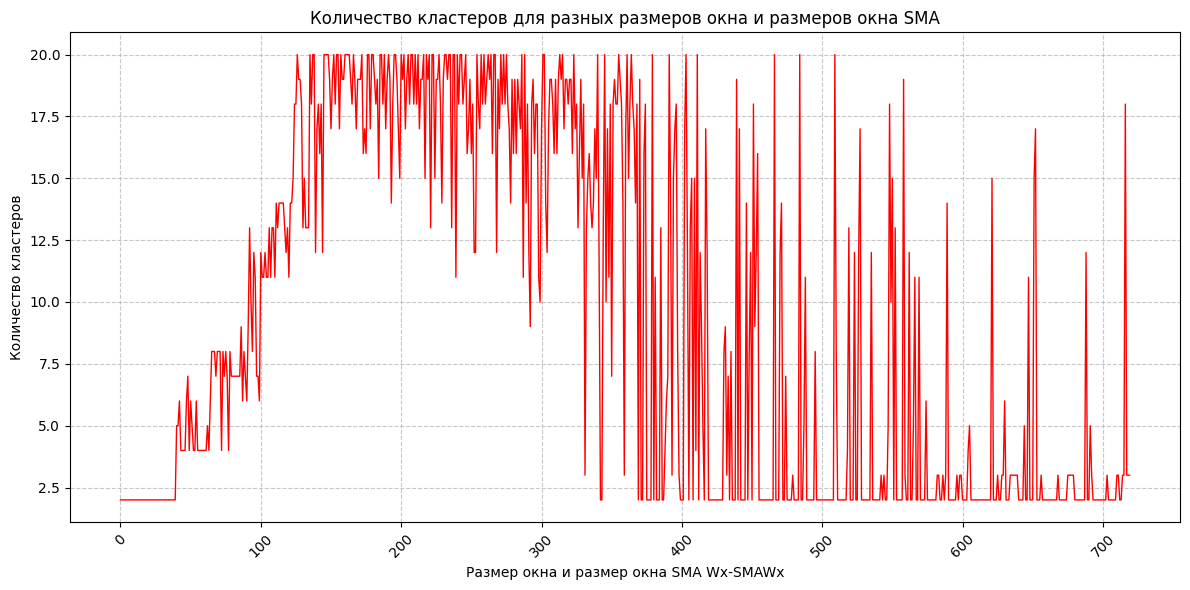

In [319]:
buffer_X_titles = []

for index in range(len(buffer_of_silhouette_scores_DELTA['window_size'])):
    buffer_X_titles.append(f"W:{buffer_of_silhouette_scores_DELTA['window_size'][index]}-SMAW:{buffer_of_silhouette_scores_DELTA['sma_window_size'][index]}")


plt.figure(figsize=(12, 6))
# plt.plot(buffer_X_titles, [i["best_count_of_clusters"] for i in buffer_of_silhouette_scores_DELTA['silhouette_score']], linewidth=1, color='red')
plt.plot([i["best_count_of_clusters"] for i in buffer_of_silhouette_scores_DELTA['silhouette_score']], linewidth=1, color='red')
plt.title(f"Количество кластеров для разных размеров окна и размеров окна SMA")
plt.xlabel('Размер окна и размер окна SMA Wx-SMAWx')
plt.ylabel('Количество кластеров')

# Поворачиваем метки на оси X для лучшей читаемости
plt.xticks(rotation=45)

# Добавляем сетку
plt.grid(True, linestyle='--', alpha=0.7)

# Настраиваем расположение элементов
plt.tight_layout()

# Показываем график
plt.show() 

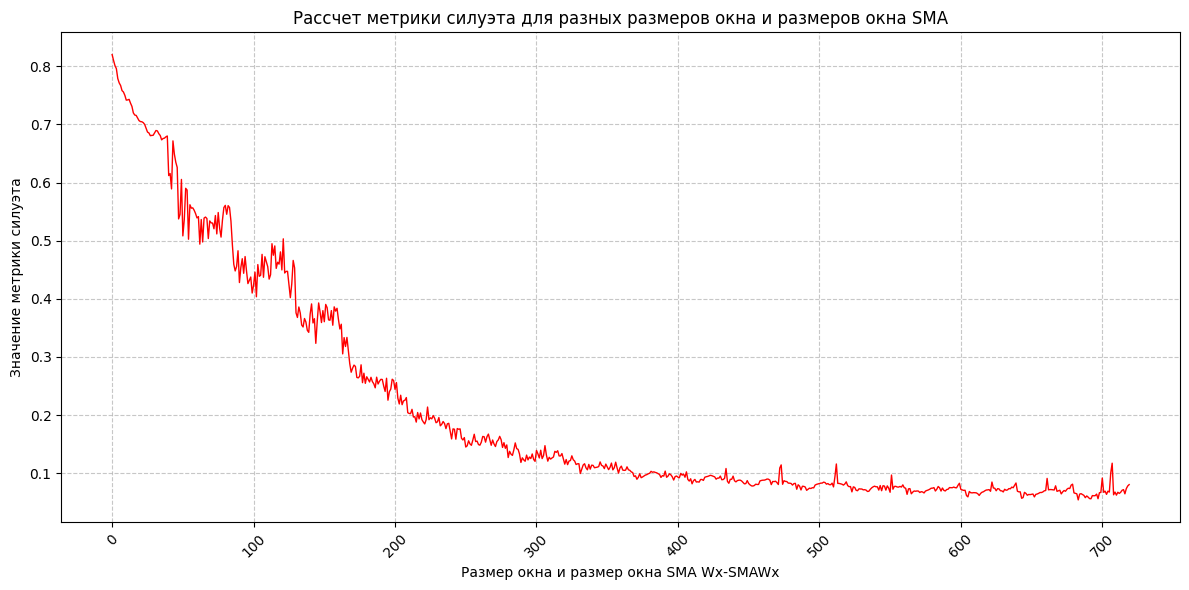

In [321]:
plt.figure(figsize=(12, 6))
# plt.plot(buffer_X_titles, [i["best_count_of_clusters"] for i in buffer_of_silhouette_scores_DELTA['silhouette_score']], linewidth=1, color='red')
plt.plot([i["best_silhouette_score"] for i in buffer_of_silhouette_scores_DELTA['silhouette_score']], linewidth=1, color='red')
plt.title(f"Рассчет метрики силуэта для разных размеров окна и размеров окна SMA")
plt.xlabel('Размер окна и размер окна SMA Wx-SMAWx')
plt.ylabel('Значение метрики силуэта')

# Поворачиваем метки на оси X для лучшей читаемости
plt.xticks(rotation=45)

# Добавляем сетку
plt.grid(True, linestyle='--', alpha=0.7)

# Настраиваем расположение элементов
plt.tight_layout()

# Показываем график
plt.show() 